# Survey data 

Analysis after (phase 2) data collection completed.

Using survey data only (no Amazon data)

- Analysis for behavior experiments
    - what impacts sharing behavior?
        - how does share rate differ by experiment arm?
        - how does share rate differ by demographic group?
        - and more...
    - what is the difference between how real monetary bonuses impact sharing vs hypothetical monetary bonuses?
- Analysis for other survey questions

Also check:

- Data validation: is the number of completions consistent across experiment arms?
- Overall share rate

In [1]:
import re

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chisquare
import statsmodels.api as sm
import statsmodels.formula.api as smf

data_filepath = '../data/survey-data/survey.csv'
fields_filepath = '../data/survey-data/fields.csv'

### Reading in data and minor transforms

In [2]:
# Reminder: Here are the fields
fields_df = pd.read_csv(fields_filepath, index_col=0)
fields_df

,fields
Duration (in seconds),Duration (in seconds)
RecordedDate,Recorded Date
ResponseId,Response ID
Q-prolific,What is your Prolific ID?
Q-prolific-mturk,Do you also complete surveys (or HITs) using A...
q-demos-age,What is your age group?
Q-demos-hispanic,"Are you of Spanish, Hispanic, or Latino origin?"
Q-demos-race,Choose one or more races that you consider you...
Q-demos-education,What is the highest level of education you hav...
Q-demos-income,What was your total household income before ta...


In [3]:
df = pd.read_csv(data_filepath)
print('shape:', df.shape)
print('all fields:', df.columns)
df.head(2)

shape: (6325, 41)
all fields: Index(['Duration (in seconds)', 'RecordedDate', 'ResponseId',
       'Q-prolific-mturk', 'q-demos-age', 'Q-demos-hispanic', 'Q-demos-race',
       'Q-demos-education', 'Q-demos-income', 'Q-demos-gender',
       'Q-sexual-orientation', 'Q-demos-state', 'Q-amazon-use-howmany',
       'Q-amazon-use-hh-size', 'Q-amazon-use-how-oft', 'Q-substance-use_1',
       'Q-substance-use_2', 'Q-substance-use_3', 'Q-personal_1',
       'Q-personal_2', 'Q-life-changes', 'Q-control', 'Q-altruism',
       'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'Q-data-value-05',
       'Q-data-value-20', 'Q-data-value-50', 'Q-data-value-100',
       'Q-data-value-any', 'Q-data-value-any_1_TEXT', 'Q-sell-YOUR-data',
       'Q-sell-consumer-data', 'Q-small-biz-use', 'Q-census-use',
       'Q-research-society', 'Q-attn-check', 'showdata', 'incentive',
       'connect'],
      dtype='object')


,Duration (in seconds),RecordedDate,ResponseId,Q-prolific-mturk,q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,...,Q-data-value-any_1_TEXT,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Q-attn-check,showdata,incentive,connect
0,332,9/21/2022 10:00:17,R_1ou69fj4DQGsVcp,NaN,35 - 44 years,No,Black or African American,High school diploma or GED,"$25,000 - $49,999",Female,...,NaN,No,No,No,No,No,"Yes,No,I don't know",False,bonus-50,NaN
1,488,9/21/2022 10:02:24,R_24dboHVOzohx1kw,NaN,25 - 34 years,No,White or Caucasian,Bachelor's degree,"$25,000 - $49,999",Male,...,NaN,Yes if I get part of the profit,Yes,No,Yes,Yes,"Yes,No,I don't know",False,bonus-05,NaN


#### Minor data transformations 

In [4]:
# Handle the '$' symbols in the Q-demos-income answers
dollar_trans = str.maketrans({'$':r'\$'})
df['Q-demos-income'] = df['Q-demos-income'].apply(lambda s: s.translate(dollar_trans))

In [5]:
# Map education level group name 'Graduate or professional degree (MA, MS, MBA, PhD, JD, MD, DDS, etc)'
# to shorter 'Graduate or professional degree'
grad = 'Graduate or professional degree'
df['Q-demos-education'] = df['Q-demos-education'].apply(lambda s: grad if 'Graduate' in s else s)

In [6]:
df.head(2)

,Duration (in seconds),RecordedDate,ResponseId,Q-prolific-mturk,q-demos-age,Q-demos-hispanic,Q-demos-race,Q-demos-education,Q-demos-income,Q-demos-gender,...,Q-data-value-any_1_TEXT,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,Q-attn-check,showdata,incentive,connect
0,332,9/21/2022 10:00:17,R_1ou69fj4DQGsVcp,NaN,35 - 44 years,No,Black or African American,High school diploma or GED,"\$25,000 - \$49,999",Female,...,NaN,No,No,No,No,No,"Yes,No,I don't know",False,bonus-50,NaN
1,488,9/21/2022 10:02:24,R_24dboHVOzohx1kw,NaN,25 - 34 years,No,White or Caucasian,Bachelor's degree,"\$25,000 - \$49,999",Male,...,NaN,Yes if I get part of the profit,Yes,No,Yes,Yes,"Yes,No,I don't know",False,bonus-05,NaN


## Sharing behavior

In [7]:
df[
    ['Q-control', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'Q-altruism', 'showdata', 'incentive']
].head()

,Q-control,Q-bonus-05,Q-bonus-20,Q-bonus-50,Q-altruism,showdata,incentive
0,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),NaN,False,bonus-50
1,NaN,Decline,NaN,NaN,NaN,False,bonus-05
2,NaN,Consent to share (receive $0.05 bonus),NaN,NaN,NaN,False,bonus-05
3,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),NaN,False,bonus-50
4,Consent to share,NaN,NaN,NaN,NaN,True,control


In [8]:
# add boolean indicating share
df['share'] = df[
    ['Q-control', 'Q-altruism', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'incentive']
].apply(lambda r: 1 if 'consent' in str(r['Q-'+r['incentive']]).lower() else 0, axis=1)
df[['Q-control', 'Q-altruism', 'Q-bonus-05', 'Q-bonus-20', 'Q-bonus-50', 'showdata', 'incentive', 'share']].head()

,Q-control,Q-altruism,Q-bonus-05,Q-bonus-20,Q-bonus-50,showdata,incentive,share
0,NaN,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),False,bonus-50,1
1,NaN,NaN,Decline,NaN,NaN,False,bonus-05,0
2,NaN,NaN,Consent to share (receive $0.05 bonus),NaN,NaN,False,bonus-05,1
3,NaN,NaN,NaN,NaN,Consent to share (receive $0.50 bonus),False,bonus-50,1
4,Consent to share,NaN,NaN,NaN,NaN,True,control,1


Aggregate the data

Make a table:
```
incentive, showdata, count, share rate
```

Sort the incentives in order to improve plotting. Order:
- control
- bonus-05
- bonus-20
- bonus-50

In [9]:
# put the incentives in order desired
incentives_list = ['control', 'bonus-05', 'bonus-20', 'bonus-50', 'altruism']

def get_aggregate_share_df(df, extra_groupby=None):
    groupbys = ['incentive','showdata'] + ([] if extra_groupby is None else [extra_groupby])
    return (df.groupby(groupbys)['share'].agg(['count','mean']).round(3)
            .reset_index().set_index('incentive').loc[incentives_list].reset_index())

agg_share_df = get_aggregate_share_df(df)
agg_share_df

,incentive,showdata,count,mean
0,control,False,636,0.763
1,control,True,639,0.779
2,bonus-05,False,647,0.720
3,bonus-05,True,618,0.785
4,bonus-20,False,648,0.765
5,bonus-20,True,602,0.834
6,bonus-50,False,624,0.830
7,bonus-50,True,616,0.888
8,altruism,False,653,0.767
9,altruism,True,642,0.816


In [10]:
# overall
N = agg_share_df['count'].sum()
overall_share_rate = df['share'].mean().round(3)

print('N = %s' % N)
print('overall share rate: %s' % overall_share_rate)

N = 6325
overall share rate: 0.794


In [11]:
# What about for just the control condition?
def get_control_df(df=df):
    return df[df['incentive']=='control']
control_df = get_control_df(df)
control_N = len(control_df)
control_share_rate = control_df['share'].mean().round(3)
print('control N = %s' % control_N)
print('control share rate: %s' % control_share_rate)

control N = 1275
control share rate: 0.771


In [12]:
def plot_count(pdf, ax):
    width = 0.4
    (pdf[pdf['showdata']==False]['count']
     .plot(
        kind='bar', color='lightgray', edgecolor='black', #hatch='//',
        label='show data: False',
        ax=ax, width=width, position=1
    ))
    (pdf[pdf['showdata']==True]['count']
     .plot(
        kind='bar', color='black', 
        edgecolor='black', 
        label='show data: True',
        ax=ax, width=width, position=0)
    )
    ax.set_ylabel('Completions')
    #ax.set_xlabel('incentive (random experiment arm)')
    ax.set_xlim([-0.5,4.5])
    ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
    _ = ax.set_xticklabels(pdf[pdf['showdata']==True]['incentive'], rotation=0)

#### Data check: is the number of completions consistent across experiment arms?

Use chi-square test of homogeneity.

Null hypothesis: Completions count is the same across experimental arms

chi-square test null hypothesis: Completions count is the same across experimental arms
chi-square test result: stat=3.953, p-value=0.914
We do not reject the null hypothesis


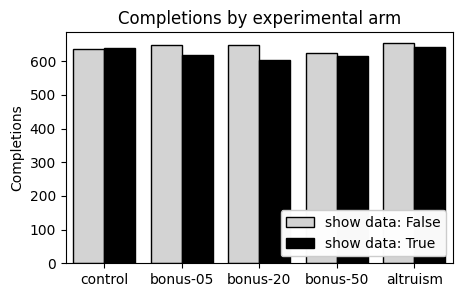

In [13]:
# plot count
fig,ax = plt.subplots(1,1, figsize=(5,3))#, dpi=150)
ax.set_title('Completions by experimental arm')
plot_count(agg_share_df, ax)
# chi-square test
(statistic, pvalue) = chisquare(agg_share_df['count'])
print('chi-square test null hypothesis: Completions count is the same across experimental arms')
print('chi-square test result: stat=%0.3f, p-value=%0.3f' % (statistic, pvalue))
if pvalue > 0.05:
    print('We do not reject the null hypothesis')
else:
    print('We reject the null hypothesis')

In [14]:
def plot_share_rate(pdf, ax, overall_share_rate=overall_share_rate):
    width = 0.4
    (pdf[pdf['showdata']==False]['mean']
     .plot(
        kind='bar', color='lightgray', edgecolor='black', #hatch='//',
        label='show data: False',
        ax=ax, width=width, position=1
    ))
    (pdf[pdf['showdata']==True]['mean']
     .plot(
        kind='bar', color='black', 
        edgecolor='black', 
        label='show data: True',
        ax=ax, width=width, position=0)
    )
    if overall_share_rate is not None:
        ax.hlines(overall_share_rate, -1, 5, color='gray', label='overall')
    ax.set_ylabel('Share rate')
    #ax.set_xlabel('incentive (random experiment arm)')
    ax.set_xlim([-0.5,4.5])
    ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
    ax.set_ylim([0,1])
    _ = ax.set_xticklabels(pdf[pdf['showdata']==True]['incentive'], rotation=0)

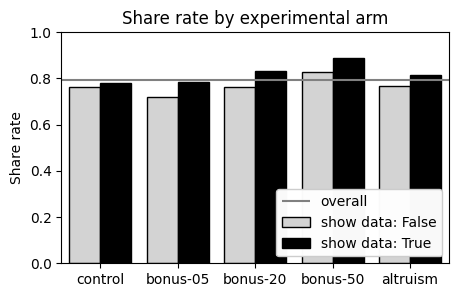

In [15]:
fig,ax = plt.subplots(1,1, figsize=(5,3), dpi=100)
ax.set_title('Share rate by experimental arm')
plot_share_rate(agg_share_df, ax)

observations for more analysis below:

- showdata=true consistently higher share rate
- more money reward --> more sharing
- incentive bonus: \$0.05 x (show data=False) has negative effect compared to control
- incentive: altruism x (show data=True) increases sharing vs control

## Helper functions for analysis

In [16]:
# displaying / printing helpers
def get_predictors_table(model):
    return pd.DataFrame({
        'B (log odds)': model.params.apply(round, args=([3])),
        'Odds Ratio': np.exp(model.params).apply(round, args=([3])), 
        '95% CI for Odds Ratio': (
            np.exp(model.conf_int())
            .apply(lambda r: '[%0.3f, %0.3f]'%(r[0], r[1]), axis=1)
        ),
        'P-value': model.pvalues.apply(round, args=([3]))
    }).rename_axis('Predictor')

## Effect of incentives and showdata

In [300]:
formula = "share ~ C(incentive, Treatment(reference='control')) + showdata"
model = smf.logit(formula=formula, data=df).fit()
display(model.summary2())
display(get_predictors_table(model))

Optimization terminated successfully.
         Current function value: 0.502463
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.012     
Dependent Variable:               share                        AIC:                          6368.1524 
Date:                             2023-05-19 16:56             BIC:                          6408.6660 
No. Observations:                 6325                         Log-Likelihood:               -3178.1   
Df Model:                         5                            LL-Null:                      -3217.0   
Df Residuals:                     6319                         LLR p-value:                  2.3286e-15
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.0617   0.0728 14.5939 0.0000  0.9191 1.2043
C(incentive, Treatment(reference='control'))[T.altruism]  0.1224   0.0957  1.2789 0.2009 -0.0652 0.3100
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1022   0.0934 -1.0946 0.2737 -0.2852 0.0808
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1694   0.0972  1.7417 0.0816 -0.0212 0.3599
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.5957   0.1055  5.6447 0.0000  0.3888 0.8025
showdata[T.True]                                          0.3171   0.0629  5.0404 0.0000  0.1938 0.4405
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.062,2.891,"[2.507, 3.334]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.122,1.130,"[0.937, 1.363]",0.201
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.102,0.903,"[0.752, 1.084]",0.274
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.169,1.185,"[0.979, 1.433]",0.082
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.596,1.814,"[1.475, 2.231]",0.000
showdata[T.True],0.317,1.373,"[1.214, 1.553]",0.000


Across all incentives:
participants in the showdata:true experiment arms had 1.37 times the odds of sharing over showdata:false

### Interaction effect between incentive and showdata

- Effect of showdata:true is higher for incentives other than 'control' 
- The effect  size increases with monetary bonus and is higher for altruism incentive.

But there is no significant interaction effect between showdata and incentive – so we cannot make scientific claims about this


In [17]:
formula = "share ~ C(incentive, Treatment(reference='control'))*showdata"
model = smf.logit(formula=formula, data=df).fit()
display(model.summary2())

Optimization terminated successfully.
         Current function value: 0.502108
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                     Results: Logit
========================================================================================================================
Model:                                 Logit                              Pseudo R-squared:                   0.013     
Dependent Variable:                    share                              AIC:                                6371.6680 
Date:                                  2023-05-22 13:58                   BIC:                                6439.1906 
No. Observations:                      6325                               Log-Likelihood:                     -3175.8   
Df Model:                              9                                  LL-Null:                            -3217.0   
Df Residuals:                          6315                               LLR p-value:                        5.4719e-14
Converged:                             1.0000                             Scale:                              1.0000    
No. Iterations:                        6.0000                                                                           
------------------------------------------------------------------------------------------------------------------------
                                                                           Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  1.1669   0.0932 12.5214 0.0000  0.9842 1.3495
C(incentive, Treatment(reference='control'))[T.altruism]                   0.0259   0.1314  0.1968 0.8440 -0.2316 0.2833
C(incentive, Treatment(reference='control'))[T.bonus-05]                  -0.2212   0.1279 -1.7295 0.0837 -0.4718 0.0295
C(incentive, Treatment(reference='control'))[T.bonus-20]                   0.0158   0.1315  0.1204 0.9042 -0.2418 0.2735
C(incentive, Treatment(reference='control'))[T.bonus-50]                   0.4197   0.1416  2.9639 0.0030  0.1421 0.6972
showdata[T.True]                                                           0.0950   0.1334  0.7121 0.4764 -0.1664 0.3563
C(incentive, Treatment(reference='control'))[T.altruism]:showdata[T.True]  0.2031   0.1917  1.0596 0.2893 -0.1726 0.5788
C(incentive, Treatment(reference='control'))[T.bonus-05]:showdata[T.True]  0.2531   0.1872  1.3524 0.1762 -0.1137 0.6200
C(incentive, Treatment(reference='control'))[T.bonus-20]:showdata[T.True]  0.3358   0.1959  1.7141 0.0865 -0.0482 0.7197
C(incentive, Treatment(reference='control'))[T.bonus-50]:showdata[T.True]  0.3888   0.2132  1.8235 0.0682 -0.0291 0.8068
========================================================================================================================

"""

### Focusing on impact of showing participants data (show data=true)

The showdata:true effect is not statistically signiciant when limiting to incentive=control.

Is the showdata:true effect significant when limiting to any of the incentive treatments?

For which is this the case?

Note since there is no interaction effect, so this is just exploratory.

In [20]:
formula = 'share ~ showdata'
incentives = ['control', 'altruism', 'bonus-05', 'bonus-20', 'bonus-50']
for incentive in incentives:
    print('\n--- incentive=%s ----\n' % incentive)
    model = smf.logit(formula=formula, data=df[df['incentive']==incentive]).fit()
    display(model.summary2())
    display(get_predictors_table(model))


--- incentive=control ----

Optimization terminated successfully.
         Current function value: 0.537890
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.000    
Dependent Variable: share            AIC:              1375.6196
Date:               2023-05-22 13:59 BIC:              1385.9210
No. Observations:   1275             Log-Likelihood:   -685.81  
Df Model:           1                LL-Null:          -686.06  
Df Residuals:       1273             LLR p-value:      0.47627  
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------
Intercept          1.1669   0.0932 12.5214 0.0000  0.9842 1.3495
showdata[T.True]   0.0950   0.1334  0.7121 0.4764 -0.1664 0.3563
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.167,3.212,"[2.676, 3.856]",0.000
showdata[T.True],0.095,1.100,"[0.847, 1.428]",0.476



--- incentive=altruism ----

Optimization terminated successfully.
         Current function value: 0.510134
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.004    
Dependent Variable: share            AIC:              1325.2473
Date:               2023-05-22 13:59 BIC:              1335.5798
No. Observations:   1295             Log-Likelihood:   -660.62  
Df Model:           1                LL-Null:          -662.98  
Df Residuals:       1293             LLR p-value:      0.029891 
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept           1.1927   0.0926 12.8803 0.0000 1.0112 1.3742
showdata[T.True]    0.2981   0.1377  2.1649 0.0304 0.0282 0.5679
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.193,3.296,"[2.749, 3.952]",0.00
showdata[T.True],0.298,1.347,"[1.029, 1.765]",0.03



--- incentive=bonus-05 ----

Optimization terminated successfully.
         Current function value: 0.557574
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.005    
Dependent Variable: share            AIC:              1414.6616
Date:               2023-05-22 13:59 BIC:              1424.9473
No. Observations:   1265             Log-Likelihood:   -705.33  
Df Model:           1                LL-Null:          -708.87  
Df Residuals:       1263             LLR p-value:      0.0077898
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept           0.9457   0.0876 10.7976 0.0000 0.7740 1.1173
showdata[T.True]    0.3481   0.1313  2.6504 0.0080 0.0907 0.6055
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.946,2.575,"[2.168, 3.057]",0.000
showdata[T.True],0.348,1.416,"[1.095, 1.832]",0.008



--- incentive=bonus-20 ----

Optimization terminated successfully.
         Current function value: 0.498952
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.007    
Dependent Variable: share            AIC:              1251.3808
Date:               2023-05-22 13:59 BIC:              1261.6425
No. Observations:   1250             Log-Likelihood:   -623.69  
Df Model:           1                LL-Null:          -628.27  
Df Residuals:       1248             LLR p-value:      0.0024865
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     5.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept           1.1827   0.0927 12.7570 0.0000 1.0010 1.3644
showdata[T.True]    0.4307   0.1435  3.0020 0.0027 0.1495 0.7120
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.183,3.263,"[2.721, 3.913]",0.000
showdata[T.True],0.431,1.538,"[1.161, 2.038]",0.003



--- incentive=bonus-50 ----

Optimization terminated successfully.
         Current function value: 0.403532
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
================================================================
Model:              Logit            Pseudo R-squared: 0.009    
Dependent Variable: share            AIC:              1004.7588
Date:               2023-05-22 13:59 BIC:              1015.0045
No. Observations:   1240             Log-Likelihood:   -500.38  
Df Model:           1                LL-Null:          -504.69  
Df Residuals:       1238             LLR p-value:      0.0033243
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     6.0000                                      
----------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept           1.5865   0.1066 14.8825 0.0000 1.3776 1.7955
showdata[T.True]    0.4838   0.1664  2.9077 0.0036 0.1577 0.8099
================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.587,4.887,"[3.965, 6.022]",0.000
showdata[T.True],0.484,1.622,"[1.171, 2.248]",0.004


```
This effect varies by incentive arm. 
This effect is not statistically significant for the control, but is statistically significant for all other incentive arms.
The effect  size increases with monetary bonus.

incentive=control: Treatment is not statistically significant
For all other incentives, p < 0.05
incentive=altruism
showdata:true experiment arm had 1.35 times the odds of sharing over showdata:false
incentive=bonus:0.05
showdata:true experiment arm had 1.4 times the odds of sharing over showdata:false
incentive=bonus:0.20
showdata:true experiment arm had 1.54 times the odds of sharing over showdata:false
incentive=bonus:0.50
showdata:true experiment arm had 1.62 times the odds of sharing over showdata:false

```

## Effect of incentives

Look across both showdata:true/false

Look at each of showdata:true/false independently

Note since there is no interaction effect, this is exploratory.

Across all data

In [21]:
# Across all data
formula = "share ~ C(incentive, Treatment(reference='control'))"
model = smf.logit(formula=formula, data=df).fit()
display(model.summary2())
display(get_predictors_table(model))

Optimization terminated successfully.
         Current function value: 0.504486
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.008     
Dependent Variable:               share                        AIC:                          6391.7430 
Date:                             2023-05-22 14:00             BIC:                          6425.5043 
No. Observations:                 6325                         Log-Likelihood:               -3190.9   
Df Model:                         4                            LL-Null:                      -3217.0   
Df Residuals:                     6320                         LLR p-value:                  1.1999e-10
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.2139   0.0666 18.2129 0.0000  1.0832 1.3445
C(incentive, Treatment(reference='control'))[T.altruism]  0.1202   0.0955  1.2583 0.2083 -0.0670 0.3074
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1057   0.0932 -1.1350 0.2564 -0.2883 0.0768
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1625   0.0970  1.6747 0.0940 -0.0277 0.3526
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.5921   0.1053  5.6211 0.0000  0.3856 0.7985
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.214,3.366,"[2.954, 3.836]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.120,1.128,"[0.935, 1.360]",0.208
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.106,0.900,"[0.750, 1.080]",0.256
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.162,1.176,"[0.973, 1.423]",0.094
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.592,1.808,"[1.471, 2.222]",0.000


By showdata arm

In [22]:
print('---- For showdata:True ----')
formula = "share ~ C(incentive, Treatment(reference='control'))"
model = smf.logit(formula=formula, data=df[df['showdata']==True]).fit()
display(model.summary2())
display(get_predictors_table(model))

---- For showdata:True ----
Optimization terminated successfully.
         Current function value: 0.465866
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
======================================================================================================
Model:                           Logit                        Pseudo R-squared:             0.012     
Dependent Variable:              share                        AIC:                          2914.2069 
Date:                            2023-05-22 14:01             BIC:                          2944.4300 
No. Observations:                3117                         Log-Likelihood:               -1452.1   
Df Model:                        4                            LL-Null:                      -1469.2   
Df Residuals:                    3112                         LLR p-value:                  6.5344e-07
Converged:                       1.0000                       Scale:                        1.0000    
No. Iterations:                  6.0000                                                               
------------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
------------------------------------------------------------------------------------------------------
Intercept                                                1.2618   0.0954 13.2275 0.0000  1.0749 1.4488
C(incentive, Treatment(reference='control'))[T.altruism] 0.2290   0.1396  1.6404 0.1009 -0.0446 0.5025
C(incentive, Treatment(reference='control'))[T.bonus-05] 0.0320   0.1367  0.2338 0.8151 -0.2359 0.2998
C(incentive, Treatment(reference='control'))[T.bonus-20] 0.3516   0.1452  2.4209 0.0155  0.0669 0.6362
C(incentive, Treatment(reference='control'))[T.bonus-50] 0.8085   0.1594  5.0709 0.0000  0.4960 1.1210
======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.262,3.532,"[2.930, 4.258]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.229,1.257,"[0.956, 1.653]",0.101
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.032,1.032,"[0.790, 1.350]",0.815
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.352,1.421,"[1.069, 1.889]",0.015
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.809,2.245,"[1.642, 3.068]",0.000


In [26]:
print('---- For showdata:False -----')
formula = "share ~ C(incentive, Treatment(reference='control'))"
model = smf.logit(formula=formula, data=df[df['showdata']==False]).fit()
display(model.summary2())
display(get_predictors_table(model))

---- For showdata:False -----
Optimization terminated successfully.
         Current function value: 0.537322
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.007     
Dependent Variable:               share                        AIC:                          3457.4611 
Date:                             2023-05-22 14:12             BIC:                          3487.8281 
No. Observations:                 3208                         Log-Likelihood:               -1723.7   
Df Model:                         4                            LL-Null:                      -1735.0   
Df Residuals:                     3203                         LLR p-value:                  0.00015511
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   5.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.1669   0.0932 12.5214 0.0000  0.9842 1.3495
C(incentive, Treatment(reference='control'))[T.altruism]  0.0259   0.1314  0.1968 0.8440 -0.2316 0.2833
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.2212   0.1279 -1.7295 0.0837 -0.4718 0.0295
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.0158   0.1315  0.1204 0.9042 -0.2418 0.2735
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4197   0.1416  2.9639 0.0030  0.1421 0.6972
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.167,3.212,"[2.676, 3.856]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.026,1.026,"[0.793, 1.328]",0.844
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.221,0.802,"[0.624, 1.030]",0.084
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.016,1.016,"[0.785, 1.315]",0.904
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.420,1.521,"[1.153, 2.008]",0.003


## Sharing differences across demographic groups

We analyze across all experiment arms, and for just control arms.

In [27]:
def add_n_labels(ax, values):
    for rect, val in zip(ax.patches, values):
        # Get X and Y placement of label from rect.
        y_value = rect.get_y() + rect.get_height() / 2
        x_value = 0.02
        ax.annotate(
            'n=%s'%val, 
            (x_value, y_value),
            va='center',
        )

        
def plot_survey_proportion_with_N(df, ax):
    ax.barh(df.index, df['survey proportion'], color='lightgray',  edgecolor='black')
    ax.set_xlabel('Proportion')
    ax.set_ylabel('')
    add_n_labels(ax, df['survey N'])
    
    
def get_share_rate_by_Q_df(Q, new_col_name=None, df=df):
    share_df = (
        df.groupby([Q])['share']
        .agg(['count','mean']).round(3).reset_index()
        .rename(columns={'count':'n', 'mean':'share rate'})
    )
    if new_col_name:
        share_df = share_df.rename({Q:new_col_name}, axis=1)
    return share_df


def plot_share_by_demo(plt_df, demo_col, ax, control_only=False):
    ax.barh(
        plt_df[demo_col], plt_df['share rate'],
        color='lightgray',  edgecolor='black'
    )
    ax.set_xlim([0,1])
    ax.set_xlabel('Share rate')
    ax.set_ylabel('')
    ax.set_title('Share rate by %s%s' % (demo_col, ' (control only)' if control_only else ''))
    share_rate = control_share_rate if control_only else overall_share_rate
    ax.axvline(share_rate, color='black')
    # annotate with labels
    add_n_labels(ax, plt_df['n'])

### Multiple demographic groups in one model

In [304]:
# build the df used for the model
keep_cols = [
    'q-demos-age', 'Q-demos-hispanic', 'Q-demos-race', 'Q-demos-education', 
    'Q-demos-income', 'Q-demos-gender', 'Q-sexual-orientation', 
    'Q-amazon-use-hh-size', 'Q-amazon-use-how-oft', 
    'Q-sell-YOUR-data', 'Q-sell-consumer-data', 'Q-small-biz-use', 'Q-census-use','Q-research-society',
    'showdata', 'incentive', 'share',
]
mdf = df[keep_cols]
# gender: restrict to Male/Female binary
mdf = (
    mdf[mdf['Q-demos-gender'].isin(['Male','Female'])]
    .rename({
        'Q-amazon-use-how-oft': 'frequency',
        'Q-sexual-orientation': 'lgbtq_status',
        'Q-research-society': 'for_research',
        'Q-demos-education': 'edu',
        'Q-demos-hispanic': 'hispanic',
        'Q-demos-income': 'income', 
        'Q-demos-gender':'gender',
        'Q-demos-race': 'race',
        'q-demos-age': 'age', 
    }, axis=1)
)
# Make very simplifying use of race:
# Aggregate 'Other' + anyone who answered 2 more more races + anyone with 'American Indian'
# Including 'American Indian' in this aggregation because otherwise this group is too small.
mdf['race'] = mdf['race'].apply(lambda r: 'Other or 2 or more races' if ((len(r.split(',')) > 1) or ('Other' in r) or ('American Indian' in r)) else r)
mdf.head(3)

,age,hispanic,race,edu,income,gender,lgbtq_status,Q-amazon-use-hh-size,frequency,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,for_research,showdata,incentive,share
0,35 - 44 years,No,Black or African American,High school diploma or GED,"\$25,000 - \$49,999",Female,heterosexual (straight),2,Less than 5 times per month,No,No,No,No,No,False,bonus-50,1
1,25 - 34 years,No,White or Caucasian,Bachelor's degree,"\$25,000 - \$49,999",Male,heterosexual (straight),1 (just me!),Less than 5 times per month,Yes if I get part of the profit,Yes,No,Yes,Yes,False,bonus-05,0
2,45 - 54 years,No,White or Caucasian,High school diploma or GED,"\$100,000 - \$149,999",Male,heterosexual (straight),4+,Less than 5 times per month,No,No,No,No,Yes,False,bonus-05,1


In [305]:
formula = "share ~ showdata + C(incentive, Treatment(reference='control'))"
formula += " + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 44 years'))"
# median household income ~$70k, use that group as reference
formula += " + C(income, Treatment(reference='\$50,000 - \$74,999'))"
formula += " + C(edu) + C(race, Treatment(reference='White or Caucasian'))"
print('formula:')
print(formula)
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

formula:
share ~ showdata + C(incentive, Treatment(reference='control')) + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 44 years')) + C(income, Treatment(reference='\$50,000 - \$74,999')) + C(edu) + C(race, Treatment(reference='White or Caucasian'))
Optimization terminated successfully.
         Current function value: 0.489796
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                        Results: Logit
===============================================================================================================================
Model:                                    Logit                                Pseudo R-squared:                     0.033     
Dependent Variable:                       share                                AIC:                                  6076.4511 
Date:                                     2023-05-25 10:21                     BIC:                                  6244.5644 
No. Observations:                         6152                                 Log-Likelihood:                       -3013.2   
Df Model:                                 24                                   LL-Null:                              -3115.0   
Df Residuals:                             6127                                 LLR p-value:                          2.1595e-30
Converged:                                1.0000                               Scale:                                1.0000    
No. Iterations:                           6.0000                                                                               
-------------------------------------------------------------------------------------------------------------------------------
                                                                                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                        0.9424   0.1223  7.7048 0.0000  0.7027  1.1821
showdata[T.True]                                                                 0.3581   0.0649  5.5162 0.0000  0.2309  0.4854
C(incentive, Treatment(reference='control'))[T.altruism]                         0.0883   0.0988  0.8938 0.3714 -0.1053  0.2819
C(incentive, Treatment(reference='control'))[T.bonus-05]                        -0.1377   0.0964 -1.4279 0.1533 -0.3267  0.0513
C(incentive, Treatment(reference='control'))[T.bonus-20]                         0.1116   0.1002  1.1140 0.2653 -0.0847  0.3079
C(incentive, Treatment(reference='control'))[T.bonus-50]                         0.5998   0.1097  5.4685 0.0000  0.3848  0.8148
C(gender, Treatment(reference='Male'))[T.Female]                                 0.3667   0.0654  5.6056 0.0000  0.2385  0.4950
C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]                   -0.1899   0.1074 -1.7674 0.0772 -0.4005  0.0207
C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]                   -0.1183   0.0847 -1.3964 0.1626 -0.2843  0.0477
C(age, Treatment(reference='35 - 44 years'))[T.45 - 54 years]                    0.0521   0.1140  0.4571 0.6476 -0.1713  0.2755
C(age, Treatment(reference='35 - 44 years'))[T.55 - 64 years]                   -0.0297   0.1397 -0.2123 0.8319 -0.3034  0.2441
C(age, Treatment(reference='35 - 44 years'))[T.65 and older]                    -0.0462   0.1965 -0.2348 0.8143 -0.4314  0.3391
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]     -0.0326   0.1155 -0.2824 0.7776 -0.2589  0.1937
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]      -0.5194   0.2183 -2.3793 0.0173 -0.9473 -0.0915
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]   0.0957   0.1086  0.8808 0.3784 -0.1172  0.3086
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]      -0.1279   0.1223 -1.0456 0.2957 -0.3676  0.1118
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]     0.1929   0.1012  1.9055 0.0567 -0.0055  0.3912
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]    -0.0859   0.1057 -0.8132 0.4161 -0.2930  0.1212
C(edu)[T.Graduate or professional degree

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.942,2.566,"[2.019, 3.261]",0.000
showdata[T.True],0.358,1.431,"[1.260, 1.625]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.088,1.092,"[0.900, 1.326]",0.371
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.138,0.871,"[0.721, 1.053]",0.153
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.112,1.118,"[0.919, 1.361]",0.265
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.600,1.822,"[1.469, 2.259]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",0.367,1.443,"[1.269, 1.640]",0.000
"C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]",-0.190,0.827,"[0.670, 1.021]",0.077
"C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]",-0.118,0.888,"[0.753, 1.049]",0.163


Including question about purchase frequency with interaction effects for purchase frequency previously found  significant

In [310]:
formula = "share ~ showdata + C(incentive, Treatment(reference='control'))"
formula += " + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 44 years'))"
# median household income ~$70k, use that group as reference
formula += " + C(income, Treatment(reference='\$50,000 - \$74,999'))"
formula += " + C(edu) + C(race, Treatment(reference='White or Caucasian'))"
formula += " + C(incentive, Treatment(reference='control'))*C(frequency)" # purchase frequency only adds information with interaction effect
print('formula:')
print(formula)
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

formula:
share ~ showdata + C(incentive, Treatment(reference='control')) + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 44 years')) + C(income, Treatment(reference='\$50,000 - \$74,999')) + C(edu) + C(race, Treatment(reference='White or Caucasian')) + C(incentive, Treatment(reference='control'))*C(frequency)
Optimization terminated successfully.
         Current function value: 0.487848
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                   Results: Logit
=====================================================================================================================================================
Model:                                          Logit                                        Pseudo R-squared:                             0.037     
Dependent Variable:                             share                                        AIC:                                          6072.4812 
Date:                                           2023-05-25 10:28                             BIC:                                          6307.8398 
No. Observations:                               6152                                         Log-Likelihood:                               -3001.2   
Df Model:                                       34                                           LL-Null:                                      -3115.0   
Df Residuals:                                   6117                                         LLR p-value:                                  1.7282e-30
Converged:                                      1.0000                                       Scale:                                        1.0000    
No. Iterations:                                 6.0000                                                                                               
-----------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              0.6415   0.1585  4.0467 0.0001  0.3308  0.9522
showdata[T.True]                                                                                       0.3647   0.0651  5.6002 0.0000  0.2371  0.4924
C(incentive, Treatment(reference='control'))[T.altruism]                                               0.4565   0.1830  2.4950 0.0126  0.0979  0.8151
C(incentive, Treatment(reference='control'))[T.bonus-05]                                               0.2727   0.1813  1.5041 0.1326 -0.0827  0.6281
C(incentive, Treatment(reference='control'))[T.bonus-20]                                               0.5199   0.1849  2.8117 0.0049  0.1575  0.8822
C(incentive, Treatment(reference='control'))[T.bonus-50]                                               1.0845   0.2082  5.2082 0.0000  0.6764  1.4926
C(gender, Treatment(reference='Male'))[T.Female]                                                       0.3687   0.0659  5.5969 0.0000  0.2396  0.4978
C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]                                         -0.2021   0.1080 -1.8717 0.0612 -0.4137  0.0095
C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]                                         -0.1239   0.0850 -1.4574 0.1450 -0.2906  0.0427
C(age, Treatment(reference='35 - 44 years'))[T.45 - 54 years]                                          0.0509   0.1144  0.4453 0.6561 -0.1732  0.2751
C(age, Treatment(reference='35 - 44 years'))[T.55 - 64 years]                                         -0.0255   0.1403 -0.1816 0.8559 -0.3004  0.2494
C(age, Treatment(reference='35 - 44 years'))[T.65 and older]                                          -0.0482   0.1972 -0.2444 0.8069 -0.4348  0.3384
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                           -0.0384   0.1160 -0.3307 0.7408 -0.2657  0.1890
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                            -0.4941   0.2193 

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.641,1.899,"[1.392, 2.591]",0.000
showdata[T.True],0.365,1.440,"[1.268, 1.636]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.456,1.579,"[1.103, 2.259]",0.013
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.273,1.314,"[0.921, 1.874]",0.133
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.520,1.682,"[1.171, 2.416]",0.005
"C(incentive, Treatment(reference='control'))[T.bonus-50]",1.084,2.958,"[1.967, 4.449]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",0.369,1.446,"[1.271, 1.645]",0.000
"C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]",-0.202,0.817,"[0.661, 1.010]",0.061
"C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]",-0.124,0.883,"[0.748, 1.044]",0.145


Including question about whether researchers should be able to use this data

In [312]:
formula = "share ~ showdata + C(incentive, Treatment(reference='control'))"
formula += " + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 44 years'))"
# median household income ~$70k, use that group as reference
formula += " + C(income, Treatment(reference='\$50,000 - \$74,999'))"
formula += " + C(edu) + C(race, Treatment(reference='White or Caucasian'))"
formula += " + C(incentive, Treatment(reference='control'))*C(frequency)" # purchase frequency only adds information with interaction effect
formula += " + C(for_research)"
print('formula:')
print(formula)
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

formula:
share ~ showdata + C(incentive, Treatment(reference='control')) + C(gender, Treatment(reference='Male')) + C(age, Treatment(reference='35 - 44 years')) + C(income, Treatment(reference='\$50,000 - \$74,999')) + C(edu) + C(race, Treatment(reference='White or Caucasian')) + C(incentive, Treatment(reference='control'))*C(frequency) + C(for_research)
Optimization terminated successfully.
         Current function value: 0.458601
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                   Results: Logit
=====================================================================================================================================================
Model:                                           Logit                                       Pseudo R-squared:                            0.094      
Dependent Variable:                              share                                       AIC:                                         5716.6230  
Date:                                            2023-05-25 10:30                            BIC:                                         5965.4307  
No. Observations:                                6152                                        Log-Likelihood:                              -2821.3    
Df Model:                                        36                                          LL-Null:                                     -3115.0    
Df Residuals:                                    6115                                        LLR p-value:                                 7.6579e-101
Converged:                                       1.0000                                      Scale:                                       1.0000     
No. Iterations:                                  6.0000                                                                                              
-----------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              0.2783   0.1775  1.5683 0.1168 -0.0695  0.6261
showdata[T.True]                                                                                       0.3840   0.0674  5.6998 0.0000  0.2520  0.5161
C(incentive, Treatment(reference='control'))[T.altruism]                                               0.3767   0.1896  1.9863 0.0470  0.0050  0.7484
C(incentive, Treatment(reference='control'))[T.bonus-05]                                               0.2595   0.1885  1.3766 0.1686 -0.1100  0.6289
C(incentive, Treatment(reference='control'))[T.bonus-20]                                               0.4742   0.1917  2.4739 0.0134  0.0985  0.8498
C(incentive, Treatment(reference='control'))[T.bonus-50]                                               1.1234   0.2148  5.2290 0.0000  0.7023  1.5444
C(gender, Treatment(reference='Male'))[T.Female]                                                       0.4075   0.0683  5.9690 0.0000  0.2737  0.5413
C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]                                         -0.3255   0.1120 -2.9066 0.0037 -0.5450 -0.1060
C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]                                         -0.1569   0.0880 -1.7833 0.0745 -0.3293  0.0155
C(age, Treatment(reference='35 - 44 years'))[T.45 - 54 years]                                          0.1275   0.1182  1.0788 0.2807 -0.1041  0.3591
C(age, Treatment(reference='35 - 44 years'))[T.55 - 64 years]                                          0.0282   0.1449  0.1942 0.8460 -0.2559  0.3122
C(age, Treatment(reference='35 - 44 years'))[T.65 and older]                                           0.0984   0.2037  0.4832 0.6290 -0.3009  0.4978
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                           -0.0714   0.1197 -0.5966 0.5508 -0.3061  0.1633
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                            -0.3878   0.2280 

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.278,1.321,"[0.933, 1.870]",0.117
showdata[T.True],0.384,1.468,"[1.287, 1.675]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.377,1.457,"[1.005, 2.114]",0.047
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.259,1.296,"[0.896, 1.876]",0.169
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.474,1.607,"[1.104, 2.339]",0.013
"C(incentive, Treatment(reference='control'))[T.bonus-50]",1.123,3.075,"[2.018, 4.685]",0.000
"C(gender, Treatment(reference='Male'))[T.Female]",0.407,1.503,"[1.315, 1.718]",0.000
"C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]",-0.325,0.722,"[0.580, 0.899]",0.004
"C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]",-0.157,0.855,"[0.719, 1.016]",0.075


### Inspecting demographic groups

### By gender

How do you describe yourself?


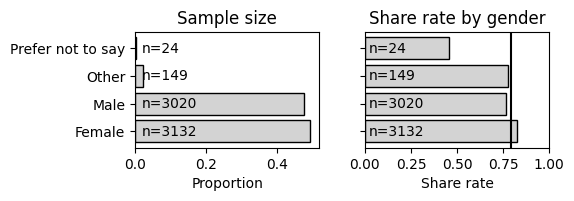

,gender,n,share rate
0,Female,3132,0.825
1,Male,3020,0.765
2,Other,149,0.779
3,Prefer not to say,24,0.458


In [31]:
Q = 'Q-demos-gender'
print(fields_df.loc[Q][0])
gender_df = df[Q].value_counts().rename('survey N').to_frame()
gender_df['survey proportion'] = gender_df['survey N']/gender_df['survey N'].sum()
figsize=(2.5, 1.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(gender_df, axes[0])
axes[0].set_title('Sample size')
colname = 'gender'
gender_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(gender_share_df, colname, axes[1])
plt.show()
gender_share_df

control only


,gender,n,share rate
0,Female,654,0.786
1,Male,584,0.764
2,Other,32,0.688
3,Prefer not to say,5,0.200


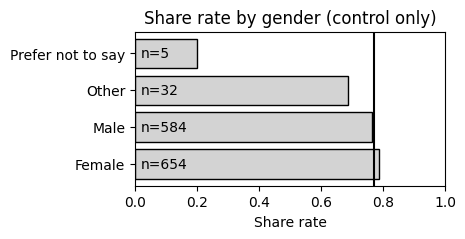

In [32]:
print('control only')
gender_share_df = get_share_rate_by_Q_df(Q, colname, df=control_df)
fig,ax = plt.subplots(1,1, figsize=(4, 0.5*len(gender_share_df)))
plot_share_by_demo(gender_share_df, colname, ax, control_only=True)
gender_share_df

Model: Are females significantly more likely to share versus males?

We limit model data to just Male/Female binary

Answer:

- Yes when we include all experimental arms
- No when just the control arm

In [33]:
# limit to just male/female
# mape male/female to binary 0/1

gender_binary_df = df[df[Q].isin(['Male','Female'])].copy()
gender_binary_df['gender'] = gender_binary_df[Q]
formula = "share ~ C(gender, Treatment(reference='Male'))"
model = smf.logit(formula=formula, data=gender_binary_df).fit()
print('\n',formula)
display(model.summary2())
display(get_predictors_table(model))
# check for just the control group too
model = smf.logit(formula=formula, data=get_control_df(gender_binary_df)).fit()
print('\nControl arm only:\n',formula)
display(model.summary2())

Optimization terminated successfully.
         Current function value: 0.503525
         Iterations 5

 share ~ C(gender, Treatment(reference='Male'))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: Logit
=============================================================================================
Model:                        Logit                     Pseudo R-squared:          0.006     
Dependent Variable:           share                     AIC:                       6199.3724 
Date:                         2023-05-22 14:13          BIC:                       6212.8214 
No. Observations:             6152                      Log-Likelihood:            -3097.7   
Df Model:                     1                         LL-Null:                   -3115.0   
Df Residuals:                 6150                      LLR p-value:               4.0181e-09
Converged:                    1.0000                    Scale:                     1.0000    
No. Iterations:               5.0000                                                         
---------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------------------------------
Intercept                                        1.1797   0.0429 27.4927 0.0000 1.0956 1.2638
C(gender, Treatment(reference='Male'))[T.Female] 0.3733   0.0637  5.8612 0.0000 0.2485 0.4981
=============================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.180,3.254,"[2.991, 3.539]",0.0
"C(gender, Treatment(reference='Male'))[T.Female]",0.373,1.453,"[1.282, 1.646]",0.0


Optimization terminated successfully.
         Current function value: 0.532260
         Iterations 5

Control arm only:
 share ~ C(gender, Treatment(reference='Male'))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                        Results: Logit
==============================================================================================
Model:                        Logit                      Pseudo R-squared:           0.001    
Dependent Variable:           share                      AIC:                        1321.8768
Date:                         2023-05-22 14:13           BIC:                        1332.1194
No. Observations:             1238                       Log-Likelihood:             -658.94  
Df Model:                     1                          LL-Null:                    -659.38  
Df Residuals:                 1236                       LLR p-value:                0.34958  
Converged:                    1.0000                     Scale:                      1.0000   
No. Iterations:               5.0000                                                          
----------------------------------------------------------------------------------------------
                                                 Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                        1.1731   0.0974 12.0427 0.0000  0.9821 1.3640
C(gender, Treatment(reference='Male'))[T.Female] 0.1275   0.1363  0.9356 0.3495 -0.1396 0.3947
==============================================================================================

"""

In [34]:
gender_agg_df = get_aggregate_share_df(gender_binary_df, extra_groupby=Q)
gender_agg_df

,incentive,showdata,Q-demos-gender,count,mean
0,control,False,Female,333,0.763
1,control,False,Male,286,0.759
2,control,True,Female,321,0.810
3,control,True,Male,298,0.768
4,bonus-05,False,Female,306,0.732
5,bonus-05,False,Male,325,0.705
6,bonus-05,True,Female,301,0.841
7,bonus-05,True,Male,301,0.734
8,bonus-20,False,Female,326,0.776
9,bonus-20,False,Male,308,0.756


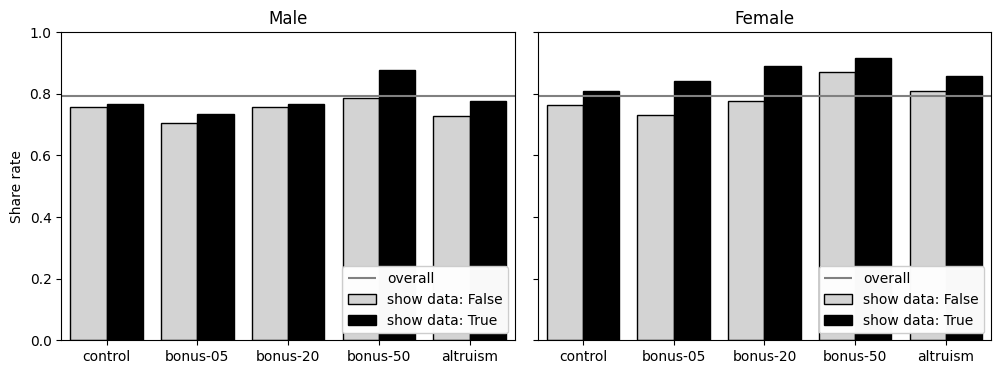

In [35]:
figsize=(6,4)
fig,axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.05)
for i, g in enumerate(['Male','Female']):
    demo_df = df[df[Q]==g]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    ax = axes[i]
    plot_share_rate(demo_agg_share_df, ax)
    ax.set_title(g)

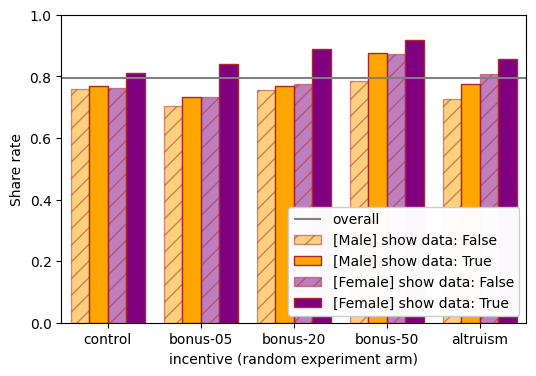

In [36]:
# Plot males and females side by side
gender_colors = {'Male':'orange', 'Female':'purple'}
width = 0.2
figsize=(6,4)
fig,ax = plt.subplots(1,1,figsize=(figsize[0],figsize[1]))
male_df = gender_agg_df[gender_agg_df[Q]=='Male']
female_df = gender_agg_df[gender_agg_df[Q]=='Female']

g = 'Male'
pdf = male_df[male_df['showdata']==False]
pdf['mean'].plot(kind='bar', ax=ax, width=width, position=2,
         color=gender_colors[g], edgecolor='brown', alpha=0.5, hatch='//', 
         label='[%s] show data: False'%g)
pdf = male_df[male_df['showdata']==True]
pdf['mean'].plot(kind='bar', ax=ax, width=width, position=1,
         color=gender_colors[g], edgecolor='brown',
         label='[%s] show data: True'%g)
g = 'Female'
pdf = female_df[female_df['showdata']==False]
pdf['mean'].plot(kind='bar', ax=ax, width=width, position=0,
         color=gender_colors[g], edgecolor='brown', alpha=0.5, hatch='//', 
         label='[%s] show data: False'%g)
pdf = female_df[female_df['showdata']==True]
pdf['mean'].plot(kind='bar', ax=ax, width=width, position=-1,
         color=gender_colors[g], edgecolor='brown',
         label='[%s] show data: True'%g)
if overall_share_rate is not None:
    ax.hlines(overall_share_rate, -1, 5, color='gray', label='overall')
ax.set_ylabel('Share rate')
ax.set_xlabel('incentive (random experiment arm)')
ax.set_xlim([-0.5,4.5])
ax.legend(facecolor='white', framealpha=0.98, loc='lower right')
ax.set_ylim([0,1])
_ = ax.set_xticklabels(pdf['incentive'], rotation=0)

### Interaction effects for gender


In [38]:
formula = "share ~ showdata*C(gender, Treatment(reference='Male')) + C(incentive, Treatment(reference='control'))*C(gender, Treatment(reference='Male'))"
print(formula)
model = smf.logit(formula=formula, data=gender_binary_df).fit()
display(model.summary2())
display(get_predictors_table(model))

share ~ showdata*C(gender, Treatment(reference='Male')) + C(incentive, Treatment(reference='control'))*C(gender, Treatment(reference='Male'))
Optimization terminated successfully.
         Current function value: 0.495813
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                     Results: Logit
========================================================================================================================================================
Model:                                           Logit                                         Pseudo R-squared:                              0.021     
Dependent Variable:                              share                                         AIC:                                           6124.4780 
Date:                                            2023-05-22 14:18                              BIC:                                           6205.1724 
No. Observations:                                6152                                          Log-Likelihood:                                -3050.2   
Df Model:                                        11                                            LL-Null:                                       -3115.0   
Df Residuals:                                    6140                                          LLR p-value:                                   2.1880e-22
Converged:                                       1.0000                                        Scale:                                         1.0000    
No. Iterations:                                  6.0000                                                                                                 
--------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                           Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                  1.0667   0.1060 10.0588 0.0000  0.8588 1.2745
showdata[T.True]                                                                                           0.2144   0.0865  2.4796 0.0132  0.0449 0.3839
C(gender, Treatment(reference='Male'))[T.Female]                                                          -0.0014   0.1485 -0.0097 0.9922 -0.2926 0.2897
C(incentive, Treatment(reference='control'))[T.altruism]                                                  -0.0636   0.1340 -0.4751 0.6347 -0.3262 0.1989
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                  -0.2285   0.1320 -1.7305 0.0835 -0.4873 0.0303
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                  -0.0035   0.1378 -0.0252 0.9799 -0.2735 0.2666
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                   0.4291   0.1472  2.9156 0.0035  0.1406 0.7176
showdata[T.True]:C(gender, Treatment(reference='Male'))[T.Female]                                          0.3042   0.1298  2.3439 0.0191  0.0498 0.5586
C(incentive, Treatment(reference='control'))[T.altruism]:C(gender, Treatment(reference='Male'))[T.Female]  0.3681   0.1967  1.8716 0.0613 -0.0174 0.7536
C(incentive, Treatment(reference='control'))[T.bonus-05]:C(gender, Treatment(reference='Male'))[T.Female]  0.2253   0.1911  1.1788 0.2385 -0.1493 0.5998
C(incentive, Treatment(reference='control'))[T.bonus-20]:C(gender, Treatment(reference='Male'))[T.Female]  0.3043   0.1988  1.5309 0.1258 -0.0853 0.6940
C(incentive, Treatment(reference='control'))[T.bonus-50]:C(gender, Treatment(reference='Male'))[T.Female]  0.4091   0.2195  1.8637 0.0624 -0.0211 0.8394
========================================================================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.067,2.906,"[2.360, 3.577]",0.000
showdata[T.True],0.214,1.239,"[1.046, 1.468]",0.013
"C(gender, Treatment(reference='Male'))[T.Female]",-0.001,0.999,"[0.746, 1.336]",0.992
"C(incentive, Treatment(reference='control'))[T.altruism]",-0.064,0.938,"[0.722, 1.220]",0.635
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.229,0.796,"[0.614, 1.031]",0.084
"C(incentive, Treatment(reference='control'))[T.bonus-20]",-0.003,0.997,"[0.761, 1.305]",0.980
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.429,1.536,"[1.151, 2.049]",0.004
"showdata[T.True]:C(gender, Treatment(reference='Male'))[T.Female]",0.304,1.356,"[1.051, 1.748]",0.019
"C(incentive, Treatment(reference='control'))[T.altruism]:C(gender, Treatment(reference='Male'))[T.Female]",0.368,1.445,"[0.983, 2.125]",0.061


### Interaction effect between gender and showdata



In [37]:
formula = "share ~ showdata*C(gender, Treatment(reference='Male'))"
print(formula)
model = smf.logit(formula=formula, data=gender_binary_df).fit()
display(model.summary2())
display(get_predictors_table(model))

share ~ showdata*C(gender, Treatment(reference='Male'))
Optimization terminated successfully.
         Current function value: 0.500669
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                Results: Logit
==============================================================================================================
Model:                             Logit                           Pseudo R-squared:                0.011     
Dependent Variable:                share                           AIC:                             6168.2308 
Date:                              2023-05-22 14:13                BIC:                             6195.1289 
No. Observations:                  6152                            Log-Likelihood:                  -3080.1   
Df Model:                          3                               LL-Null:                         -3115.0   
Df Residuals:                      6148                            LLR p-value:                     4.8128e-15
Converged:                         1.0000                          Scale:                           1.0000    
No. Iterations:                    6.0000                                                                     
--------------------------------------------------------------------------------------------------------------
                                                                  Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                                         1.0725   0.0588 18.2353 0.0000 0.9572 1.1878
showdata[T.True]                                                  0.2228   0.0861  2.5876 0.0097 0.0540 0.3916
C(gender, Treatment(reference='Male'))[T.Female]                  0.2532   0.0850  2.9788 0.0029 0.0866 0.4198
showdata[T.True]:C(gender, Treatment(reference='Male'))[T.Female] 0.2850   0.1291  2.2067 0.0273 0.0319 0.5381
==============================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.073,2.923,"[2.604, 3.280]",0.000
showdata[T.True],0.223,1.250,"[1.056, 1.479]",0.010
"C(gender, Treatment(reference='Male'))[T.Female]",0.253,1.288,"[1.090, 1.522]",0.003
"showdata[T.True]:C(gender, Treatment(reference='Male'))[T.Female]",0.285,1.330,"[1.032, 1.713]",0.027


### By income group

In [48]:
income_order = [
    'Prefer not to say', 'Less than \$25,000','\$25,000 - \$49,999',  '\$50,000 - \$74,999', 
    '\$75,000 - \$99,999',  '\$100,000 - \$149,999', '\$150,000 or more'
]

Overall

What was your total household income before taxes during the past 12 months?


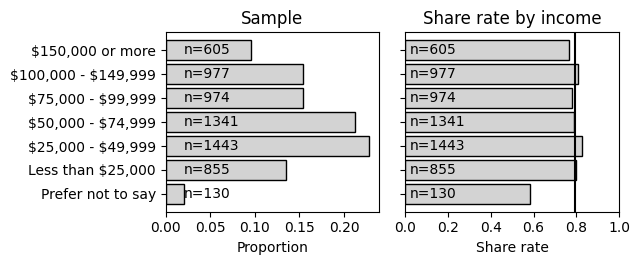

,income,n,share rate
0,Prefer not to say,130,0.585
1,"Less than \$25,000",855,0.801
2,"\$25,000 - \$49,999",1443,0.825
3,"\$50,000 - \$74,999",1341,0.791
4,"\$75,000 - \$99,999",974,0.779
5,"\$100,000 - \$149,999",977,0.807
6,"\$150,000 or more",605,0.764


In [49]:
Q = 'Q-demos-income'
print(fields_df.loc[Q][0])
income_df = df[Q].value_counts().rename('survey N').to_frame()
income_df['survey proportion'] = income_df['survey N']/income_df['survey N'].sum()
# order by income
income_df = income_df.loc[income_order]
figsize = (3.25, 2.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
ax = axes[0]
plot_survey_proportion_with_N(income_df, ax)
ax.set_title('Sample')
colname = 'income'
income_share_df = get_share_rate_by_Q_df(Q, colname)
# order by income
income_share_df = income_share_df.set_index('income').loc[income_order].reset_index()
ax = axes[1]
plot_share_by_demo(income_share_df, colname, ax)
plt.tight_layout()
plt.show()
income_share_df

Are there interaction effects between experimental arms and income groups?

Using \\$50,000 - \\$74,999 as reference 

In [50]:
formula = "share ~ showdata*C(income, Treatment(reference='\$50,000 - \$74,999')) + C(incentive, Treatment(reference='control'))*C(income, Treatment(reference='\$50,000 - \$74,999'))"
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

Optimization terminated successfully.
         Current function value: 0.495216
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                                    Results: Logit
=======================================================================================================================================================================================
Model:                                                      Logit                                                   Pseudo R-squared:                                        0.022     
Dependent Variable:                                         share                                                   AIC:                                                     6177.1400 
Date:                                                       2023-05-22 17:05                                        BIC:                                                     6459.5703 
No. Observations:                                           6152                                                    Log-Likelihood:                                          -3046.6   
Df Model:                                                   41                                                      LL-Null:                                                 -3115.0   
Df Residuals:                                               6110                                                    LLR p-value:                                             3.0196e-12
Converged:                                                  1.0000                                                  Scale:                                                   1.0000    
No. Iterations:                                             6.0000                                                                                                                     
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                                1.1221   0.1644  6.8252 0.0000  0.7999  1.4444
showdata[T.True]                                                                                                                         0.3715   0.1392  2.6690 0.0076  0.0987  0.6444
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                                                             -0.2307   0.2700 -0.8545 0.3929 -0.7599  0.2985
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                                                              -0.8125   0.4557 -1.7831 0.0746 -1.7057  0.0806
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                                                           0.1471   0.2521  0.5837 0.5594 -0.3469  0.6411
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                                                              -0.2201   0.2773 -0.7938 0.4273 -0.7635  0.3233
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                                                             0.1730   0.2338  0.7399 0.4593 -0.2852  0.6311
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                                                            -0.1747   0.2435 -0.7175 0.4731 -0.6520  0.3025
C(incentive, Treatment(reference='control'))[T.altruism]                                                                                 0.0812   0.2125  0.3822 0.7023 -0.3

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.122,3.071,"[2.225, 4.239]",0.000
showdata[T.True],0.372,1.450,"[1.104, 1.905]",0.008
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]",-0.231,0.794,"[0.468, 1.348]",0.393
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]",-0.813,0.444,"[0.182, 1.084]",0.075
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]",0.147,1.158,"[0.707, 1.899]",0.559
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]",-0.220,0.802,"[0.466, 1.382]",0.427
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]",0.173,1.189,"[0.752, 1.880]",0.459
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]",-0.175,0.840,"[0.521, 1.353]",0.473
"C(incentive, Treatment(reference='control'))[T.altruism]",0.081,1.085,"[0.715, 1.645]",0.702


Test for interaction effect only between income group and incentive

In [56]:
formula = "share ~ C(incentive, Treatment(reference='control'))*C(income, Treatment(reference='\$50,000 - \$74,999'))"
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

Optimization terminated successfully.
         Current function value: 0.498079
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                                    Results: Logit
=======================================================================================================================================================================================
Model:                                                      Logit                                                   Pseudo R-squared:                                        0.016     
Dependent Variable:                                         share                                                   AIC:                                                     6198.3635 
Date:                                                       2023-05-22 17:11                                        BIC:                                                     6433.7222 
No. Observations:                                           6152                                                    Log-Likelihood:                                          -3064.2   
Df Model:                                                   34                                                      LL-Null:                                                 -3115.0   
Df Residuals:                                               6117                                                    LLR p-value:                                             1.1654e-08
Converged:                                                  1.0000                                                  Scale:                                                   1.0000    
No. Iterations:                                             6.0000                                                                                                                     
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                         Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                                1.2840   0.1538  8.3500 0.0000  0.9826  1.5854
C(incentive, Treatment(reference='control'))[T.altruism]                                                                                 0.0809   0.2120  0.3815 0.7028 -0.3346  0.4963
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                                                -0.0262   0.2158 -0.1212 0.9035 -0.4492  0.3968
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                                                -0.1304   0.2143 -0.6086 0.5428 -0.5506  0.2897
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                                                 0.4565   0.2303  1.9821 0.0475  0.0051  0.9078
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                                                             -0.1490   0.2457 -0.6067 0.5441 -0.6305  0.3325
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                                                              -1.2150   0.4022 -3.0212 0.0025 -2.0033 -0.4268
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                                                           0.0843   0.2313  0.3642 0.7157 -0.3692  0.5377
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                                                              -0.2280   0.2564 -0.8889 0.3740 -0.7

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.284,3.611,"[2.671, 4.881]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.081,1.084,"[0.716, 1.643]",0.703
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.026,0.974,"[0.638, 1.487]",0.904
"C(incentive, Treatment(reference='control'))[T.bonus-20]",-0.130,0.878,"[0.577, 1.336]",0.543
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.456,1.578,"[1.005, 2.479]",0.047
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]",-0.149,0.862,"[0.532, 1.394]",0.544
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]",-1.215,0.297,"[0.135, 0.653]",0.003
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]",0.084,1.088,"[0.691, 1.712]",0.716
"C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]",-0.228,0.796,"[0.482, 1.316]",0.374


#### Evaluate each incentive arm separately

Q-demos-income
share ~ C(income, Treatment(reference='\$50,000 - \$74,999'))*showdata
------- control -------
Optimization terminated successfully.
         Current function value: 0.526823
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                Results: Logit
==============================================================================================================================================
Model:                                        Logit                                      Pseudo R-squared:                           0.021    
Dependent Variable:                           share                                      AIC:                                        1371.3991
Date:                                         2023-05-22 17:11                           BIC:                                        1443.5089
No. Observations:                             1275                                       Log-Likelihood:                             -671.70  
Df Model:                                     13                                         LL-Null:                                    -686.06  
Df Residuals:                                 1261                                       LLR p-value:                                0.0071530
Converged:                                    1.0000                                     Scale:                                      1.0000   
No. Iterations:                               5.0000                                                                                          
----------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                 Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                        1.0598   0.1961  5.4030 0.0000  0.6753 1.4442
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                     -0.0724   0.3327 -0.2175 0.8278 -0.7245 0.5798
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                      -0.8085   0.5408 -1.4950 0.1349 -1.8684 0.2514
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                   0.4319   0.3264  1.3232 0.1858 -0.2078 1.0716
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                      -0.2713   0.3335 -0.8136 0.4159 -0.9249 0.3823
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                     0.4779   0.2919  1.6373 0.1016 -0.0942 1.0500
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                     0.0516   0.2993  0.1723 0.8632 -0.5351 0.6382
showdata[T.True]                                                                                 0.3897   0.3036  1.2837 0.1992 -0.2053 0.9847
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]:showdata[T.True]    -0.0730   0.4809 -0.1518 0.8793 -1.0157 0.8696
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]:showdata[T.True]     -1.3342   0.7721 -1.7280 0.0840 -2.8474 0.1791
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]:showdata[T.True] -0.6168   0.4622 -1.3344 0.1821 -1.5227 0.2892
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]:showdata[T.True]      0.1487   0.5121  0.2904 0.7715 -0.8549 1.1523
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]:showdata[T.True]   -0.5147   0.4281 -1.2021 0.2293 -1.3538 0.3244
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]:showdata[T.True]   -0.2746   0.4495 -0.6109 0.5413 -1.1556 0.6064
==============================================================================================================================================

"""

------- bonus-05 -------
Optimization terminated successfully.
         Current function value: 0.550230
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                Results: Logit
===============================================================================================================================================
Model:                                         Logit                                      Pseudo R-squared:                           0.018    
Dependent Variable:                            share                                      AIC:                                        1420.0830
Date:                                          2023-05-22 17:11                           BIC:                                        1492.0826
No. Observations:                              1265                                       Log-Likelihood:                             -696.04  
Df Model:                                      13                                         LL-Null:                                    -708.87  
Df Residuals:                                  1251                                       LLR p-value:                                0.018879 
Converged:                                     1.0000                                     Scale:                                      1.0000   
No. Iterations:                                5.0000                                                                                          
-----------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                 Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                        1.1407   0.2063  5.5289 0.0000  0.7363  1.5451
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                     -0.0715   0.3178 -0.2251 0.8219 -0.6943  0.5513
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                      -1.1407   0.5146 -2.2168 0.0266 -2.1493 -0.1322
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                   0.0278   0.3155  0.0883 0.9297 -0.5906  0.6463
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                      -0.2340   0.3308 -0.7074 0.4793 -0.8823  0.4143
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                    -0.0036   0.2853 -0.0128 0.9898 -0.5629  0.5556
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                    -0.7187   0.2898 -2.4804 0.0131 -1.2866 -0.1508
showdata[T.True]                                                                                 0.2551   0.3009  0.8479 0.3965 -0.3347  0.8449
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]:showdata[T.True]     0.0168   0.4724  0.0356 0.9716 -0.9091  0.9427
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]:showdata[T.True]     -0.1010   0.7889 -0.1280 0.8981 -1.6471  1.4451
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]:showdata[T.True] -0.1525   0.4508 -0.3383 0.7352 -1.0360  0.7311
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]:showdata[T.True]     -0.0413   0.4958 -0.0832 0.9337 -1.0130  0.9305
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]:showdata[T.True]    0.0741   0.4183  0.1772 0.8594 -0.7458  0.8940
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]:showdata[T.True]    0.5216   0.4477  1.1649 0.2440 -0.3559  1.3991
================================================================================================================================

------- bonus-20 -------
Optimization terminated successfully.
         Current function value: 0.495200
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                Results: Logit
==============================================================================================================================================
Model:                                        Logit                                      Pseudo R-squared:                           0.015    
Dependent Variable:                           share                                      AIC:                                        1266.0011
Date:                                         2023-05-22 17:11                           BIC:                                        1337.8337
No. Observations:                             1250                                       Log-Likelihood:                             -619.00  
Df Model:                                     13                                         LL-Null:                                    -628.27  
Df Residuals:                                 1236                                       LLR p-value:                                0.13841  
Converged:                                    1.0000                                     Scale:                                      1.0000   
No. Iterations:                               6.0000                                                                                          
----------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                 Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                        1.0062   0.2004  5.0209 0.0000  0.6134 1.3990
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                      0.1932   0.3151  0.6130 0.5399 -0.4245 0.8109
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                      -0.6698   0.6189 -1.0822 0.2792 -1.8828 0.5432
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                   0.3801   0.3157  1.2037 0.2287 -0.2388 0.9989
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                       0.2701   0.3831  0.7049 0.4808 -0.4808 1.0209
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                     0.2465   0.2792  0.8828 0.3773 -0.3008 0.7938
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                     0.1595   0.3079  0.5180 0.6044 -0.4440 0.7630
showdata[T.True]                                                                                 0.3900   0.3001  1.2995 0.1938 -0.1982 0.9782
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]:showdata[T.True]     0.3565   0.5133  0.6945 0.4874 -0.6496 1.3626
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]:showdata[T.True]      0.6598   1.2973  0.5086 0.6110 -1.8828 3.2024
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]:showdata[T.True] -0.3140   0.4631 -0.6782 0.4977 -1.2216 0.5935
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]:showdata[T.True]     -0.0977   0.5635 -0.1734 0.8624 -1.2020 1.0067
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]:showdata[T.True]    0.3804   0.4457  0.8536 0.3933 -0.4931 1.2540
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]:showdata[T.True]   -0.1695   0.4588 -0.3694 0.7119 -1.0687 0.7298
==============================================================================================================================================

"""

------- bonus-50 -------
Optimization terminated successfully.
         Current function value: 0.396065
         Iterations 7


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                Results: Logit
==============================================================================================================================================
Model:                                        Logit                                      Pseudo R-squared:                           0.027    
Dependent Variable:                           share                                      AIC:                                        1010.2417
Date:                                         2023-05-22 17:11                           BIC:                                        1081.9618
No. Observations:                             1240                                       Log-Likelihood:                             -491.12  
Df Model:                                     13                                         LL-Null:                                    -504.69  
Df Residuals:                                 1226                                       LLR p-value:                                0.011913 
Converged:                                    1.0000                                     Scale:                                      1.0000   
No. Iterations:                               7.0000                                                                                          
----------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                 Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
----------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                        1.5559   0.2295  6.7805 0.0000  1.1061 2.0056
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                     -0.0850   0.3535 -0.2404 0.8100 -0.7779 0.6079
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                      -0.1696   0.6851 -0.2475 0.8045 -1.5123 1.1732
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                  -0.1565   0.3439 -0.4550 0.6491 -0.8305 0.5176
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                      -0.2749   0.4248 -0.6472 0.5175 -1.1075 0.5576
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                     0.3672   0.3361  1.0926 0.2746 -0.2915 1.0260
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                     0.1181   0.3631  0.3253 0.7449 -0.5935 0.8297
showdata[T.True]                                                                                 0.2036   0.3293  0.6183 0.5364 -0.4419 0.8491
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]:showdata[T.True]     0.2843   0.5334  0.5330 0.5940 -0.7612 1.3298
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]:showdata[T.True]     -1.5899   0.9618 -1.6530 0.0983 -3.4751 0.2952
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]:showdata[T.True]  0.7818   0.5745  1.3607 0.1736 -0.3443 1.9079
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]:showdata[T.True]      0.6749   0.6497  1.0388 0.2989 -0.5985 1.9483
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]:showdata[T.True]    0.1069   0.5109  0.2091 0.8343 -0.8946 1.1083
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]:showdata[T.True]    0.8014   0.5833  1.3739 0.1695 -0.3419 1.9448
==============================================================================================================================================

"""

------- altruism -------
         Current function value: 0.504832
         Iterations: 35


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                    Results: Logit
======================================================================================================================================================
Model:                                            Logit                                        Pseudo R-squared:                             0.014    
Dependent Variable:                               share                                        AIC:                                          1335.5157
Date:                                             2023-05-22 17:11                             BIC:                                          1407.8434
No. Observations:                                 1295                                         Log-Likelihood:                               -653.76  
Df Model:                                         13                                           LL-Null:                                      -662.98  
Df Residuals:                                     1281                                         LLR p-value:                                  0.14127  
Converged:                                        0.0000                                       Scale:                                        1.0000   
No. Iterations:                                   35.0000                                                                                             
------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                 Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                         1.1499    0.1861  6.1775 0.0000     0.7851    1.5147
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                       0.2082    0.3232  0.6441 0.5195    -0.4253    0.8418
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                       15.4597 1650.6587  0.0094 0.9925 -3219.7719 3250.6913
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                    0.1029    0.3145  0.3270 0.7437    -0.5136    0.7193
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                       -0.2089    0.3486 -0.5993 0.5490    -0.8922    0.4744
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                      0.1327    0.2708  0.4900 0.6241    -0.3981    0.6636
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                     -0.1283    0.2916 -0.4399 0.6600    -0.6997    0.4432
showdata[T.True]                                                                                  0.4170    0.2916  1.4301 0.1527    -0.1545    0.9884
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]:showdata[T.True]     -0.2095    0.4911 -0.4265 0.6698    -1.1721    0.7531
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]:showdata[T.True]     -16.4205 1650.6588 -0.0099 0.9921 -3251.6522 3218.8113
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]:showdata[T.True]  -0.0211    0.4783 -0.0441 0.9649    -0.9586    0.9164
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]:showdata[T.True]      -0.4219    0.4914 -0.8584 0.3907    -1.3851    0.5413
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]:showdata[T.True]     0.0401    0.4181  0.0959 0.9236    -0.7794    0.8596
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]:showdata[T.True]

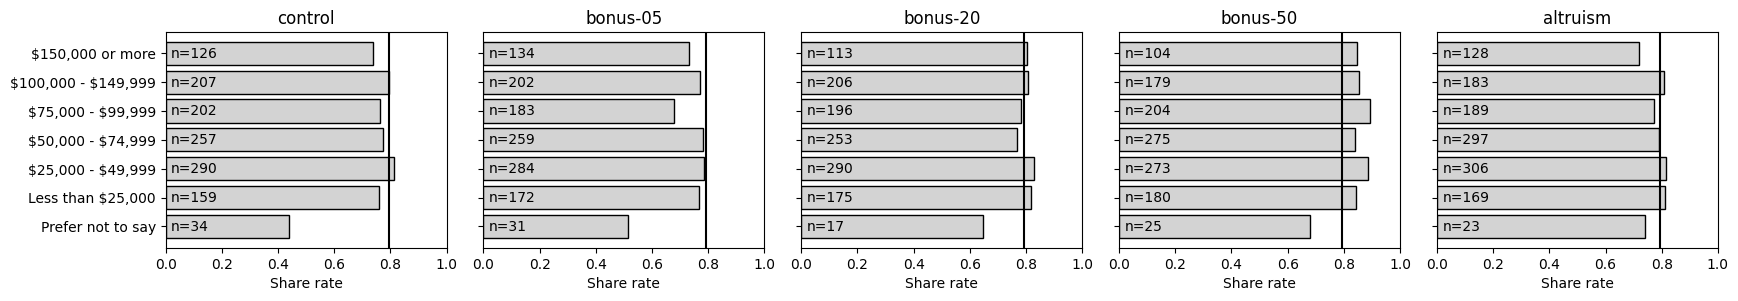

In [57]:
print(Q)
formula = "share ~ C(income, Treatment(reference='\$50,000 - \$74,999'))*showdata"
print(formula)

figsize = (3.25, 2.75)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.tight_layout()

for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['income'] = incentive_df[Q]
    print('------- %s -------' % incentive)
    income_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # order by income
    income_share_df = income_share_df.set_index('income').loc[income_order].reset_index()
    #display(income_share_df)
    # plot horizontally with the others
    plot_share_by_demo(income_share_df, colname, axes[i])
    axes[i].set_title(incentive)
    model = smf.logit(formula=formula, data=incentive_df).fit()
    display(model.summary2())
plt.show()

#### Evaluate each income group separately

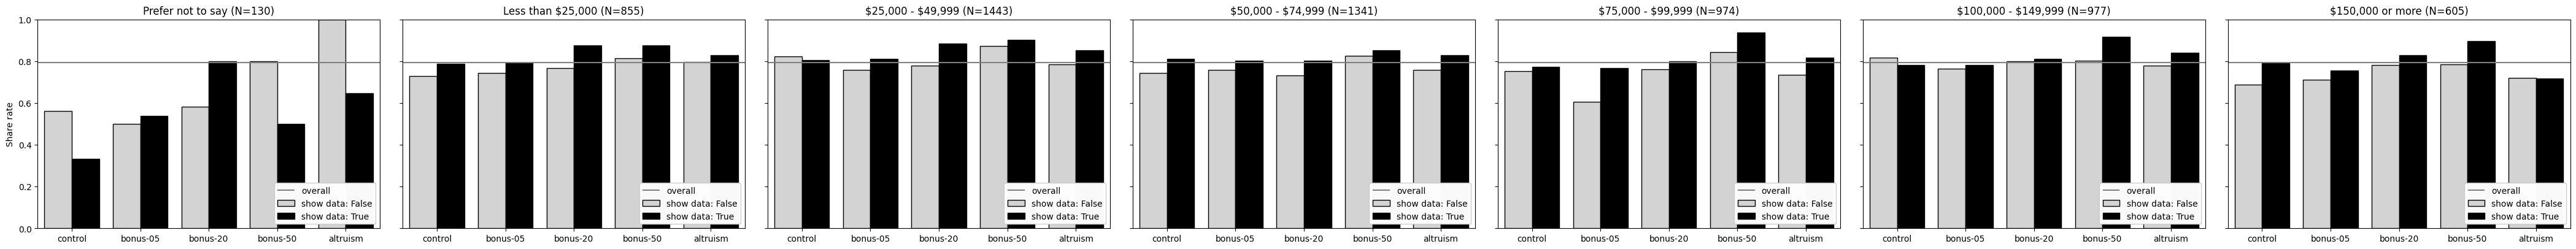

In [58]:
figsize=(6,4)
fig,axes = plt.subplots(1,7,figsize=(figsize[0]*7,figsize[1]), sharey=True)
plt.tight_layout()
for i, income in enumerate(income_order):
    demo_df = df[df[Q]==income]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (income, len(demo_df)))

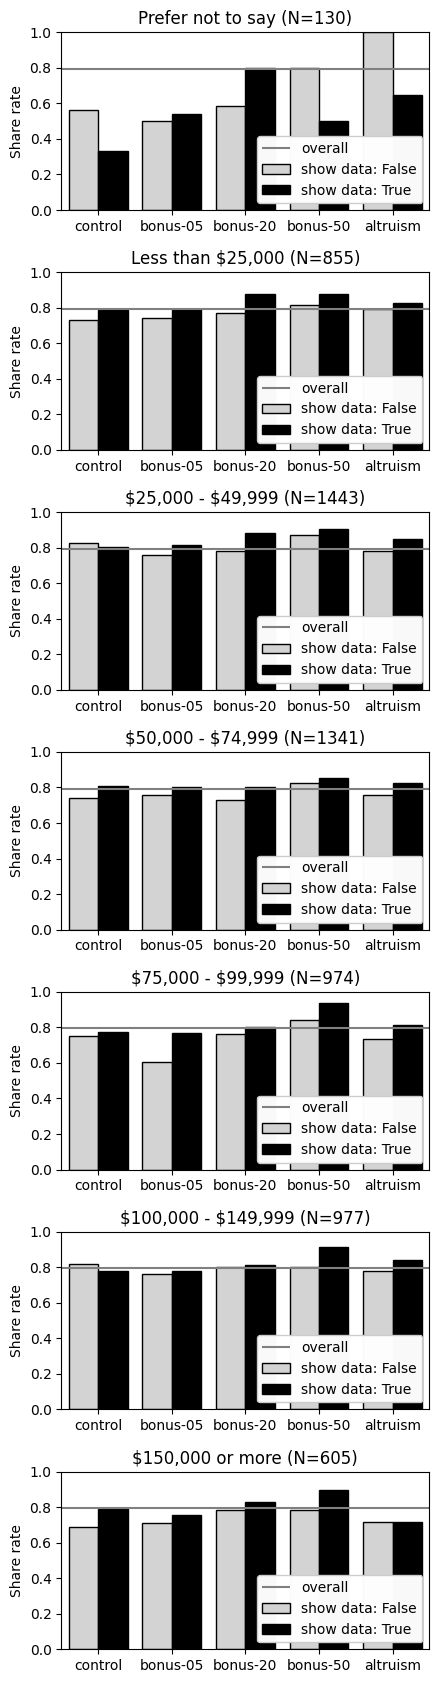

In [59]:
figsize=(4.75,3)
fig,axes = plt.subplots(7,1,figsize=(figsize[0],figsize[1]*7))
plt.subplots_adjust(hspace=0.35)
for i, income in enumerate(income_order):
    demo_df = df[df[Q]==income]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (income, len(demo_df)))

In [61]:
# Logistic reggressions to test for differences
formula = "share ~ C(incentive, Treatment(reference='control')) + showdata"
for i, income in enumerate(income_order):
    print('------- Income group: %s -------' % income)
    print(formula)
    demo_df = df[df[Q]==income]
    model = smf.logit(formula=formula, data=demo_df).fit()
    display(model.summary2())
    display(get_predictors_table(model))

------- Income group: Prefer not to say -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.641577
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                         Pseudo R-squared:              0.055   
Dependent Variable:               share                         AIC:                           178.8100
Date:                             2023-05-22 17:12              BIC:                           196.0152
No. Observations:                 130                           Log-Likelihood:                -83.405 
Df Model:                         5                             LL-Null:                       -88.239 
Df Residuals:                     124                           LLR p-value:                   0.085232
Converged:                        1.0000                        Scale:                         1.0000  
No. Iterations:                   5.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 0.0855   0.4013  0.2130 0.8314 -0.7010 0.8719
C(incentive, Treatment(reference='control'))[T.altruism]  1.4309   0.6020  2.3768 0.0175  0.2509 2.6108
C(incentive, Treatment(reference='control'))[T.bonus-05]  0.2390   0.5055  0.4728 0.6364 -0.7518 1.2299
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.7128   0.6244  1.1416 0.2536 -0.5110 1.9366
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.9315   0.5571  1.6721 0.0945 -0.1603 2.0234
showdata[T.True]                                         -0.6181   0.3849 -1.6059 0.1083 -1.3724 0.1363
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.085,1.089,"[0.496, 2.391]",0.831
"C(incentive, Treatment(reference='control'))[T.altruism]",1.431,4.182,"[1.285, 13.610]",0.017
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.239,1.270,"[0.471, 3.421]",0.636
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.713,2.040,"[0.600, 6.935]",0.254
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.932,2.538,"[0.852, 7.564]",0.094
showdata[T.True],-0.618,0.539,"[0.254, 1.146]",0.108


------- Income group: Less than \$25,000 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.492632
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                           Results: Logit
=====================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.012   
Dependent Variable:               share                        AIC:                          854.4000
Date:                             2023-05-22 17:12             BIC:                          882.9066
No. Observations:                 855                          Log-Likelihood:               -421.20 
Df Model:                         5                            LL-Null:                      -426.45 
Df Residuals:                     849                          LLR p-value:                  0.062051
Converged:                        1.0000                       Scale:                        1.0000  
No. Iterations:                   6.0000                                                             
-----------------------------------------------------------------------------------------------------
                                                         Coef.  Std.Err.   z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------------------------------------
Intercept                                                0.9476   0.2067 4.5850 0.0000  0.5425 1.3527
C(incentive, Treatment(reference='control'))[T.altruism] 0.3298   0.2718 1.2136 0.2249 -0.2028 0.8624
C(incentive, Treatment(reference='control'))[T.bonus-05] 0.0688   0.2605 0.2643 0.7916 -0.4417 0.5793
C(incentive, Treatment(reference='control'))[T.bonus-20] 0.3816   0.2714 1.4057 0.1598 -0.1504 0.9136
C(incentive, Treatment(reference='control'))[T.bonus-50] 0.5626   0.2785 2.0204 0.0433  0.0168 1.1083
showdata[T.True]                                         0.3940   0.1744 2.2591 0.0239  0.0522 0.7359
=====================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.948,2.580,"[1.720, 3.868]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.330,1.391,"[0.816, 2.369]",0.225
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.069,1.071,"[0.643, 1.785]",0.792
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.382,1.465,"[0.860, 2.493]",0.160
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.563,1.755,"[1.017, 3.029]",0.043
showdata[T.True],0.394,1.483,"[1.054, 2.087]",0.024


------- Income group: \$25,000 - \$49,999 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.457193
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                           Logit                         Pseudo R-squared:              0.013    
Dependent Variable:              share                         AIC:                           1331.4578
Date:                            2023-05-22 17:12              BIC:                           1363.1047
No. Observations:                1443                          Log-Likelihood:                -659.73  
Df Model:                        5                             LL-Null:                       -668.34  
Df Residuals:                    1437                          LLR p-value:                   0.0040884
Converged:                       1.0000                        Scale:                         1.0000   
No. Iterations:                  6.0000                                                                
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.3157   0.1634  8.0536 0.0000  0.9955 1.6359
C(incentive, Treatment(reference='control'))[T.altruism]  0.0179   0.2117  0.0845 0.9326 -0.3970 0.4328
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1841   0.2094 -0.8794 0.3792 -0.5945 0.2263
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1012   0.2171  0.4661 0.6411 -0.3243 0.5267
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.5953   0.2437  2.4427 0.0146  0.1176 1.0730
showdata[T.True]                                          0.3413   0.1408  2.4233 0.0154  0.0653 0.6173
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.316,3.727,"[2.706, 5.134]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.018,1.018,"[0.672, 1.542]",0.933
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.184,0.832,"[0.552, 1.254]",0.379
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.101,1.106,"[0.723, 1.693]",0.641
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.595,1.814,"[1.125, 2.924]",0.015
showdata[T.True],0.341,1.407,"[1.067, 1.854]",0.015


------- Income group: \$50,000 - \$74,999 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.507915
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                           Logit                         Pseudo R-squared:              0.009    
Dependent Variable:              share                         AIC:                           1374.2267
Date:                            2023-05-22 17:12              BIC:                           1405.4338
No. Observations:                1341                          Log-Likelihood:                -681.11  
Df Model:                        5                             LL-Null:                       -687.08  
Df Residuals:                    1335                          LLR p-value:                   0.035800 
Converged:                       1.0000                        Scale:                         1.0000   
No. Iterations:                  6.0000                                                                
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.0821   0.1603  6.7488 0.0000  0.7678 1.3964
C(incentive, Treatment(reference='control'))[T.altruism]  0.1010   0.2070  0.4879 0.6256 -0.3047 0.5067
C(incentive, Treatment(reference='control'))[T.bonus-05]  0.0208   0.2121  0.0979 0.9220 -0.3950 0.4365
C(incentive, Treatment(reference='control'))[T.bonus-20] -0.0519   0.2112 -0.2457 0.8059 -0.4658 0.3621
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4107   0.2226  1.8447 0.0651 -0.0257 0.8470
showdata[T.True]                                          0.3367   0.1360  2.4764 0.0133  0.0702 0.6031
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.082,2.951,"[2.155, 4.040]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.101,1.106,"[0.737, 1.660]",0.626
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.021,1.021,"[0.674, 1.547]",0.922
"C(incentive, Treatment(reference='control'))[T.bonus-20]",-0.052,0.949,"[0.628, 1.436]",0.806
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.411,1.508,"[0.975, 2.333]",0.065
showdata[T.True],0.337,1.400,"[1.073, 1.828]",0.013


------- Income group: \$75,000 - \$99,999 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.508849
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                        Pseudo R-squared:             0.036     
Dependent Variable:               share                        AIC:                          1003.2375 
Date:                             2023-05-22 17:12             BIC:                          1032.5260 
No. Observations:                 974                          Log-Likelihood:               -495.62   
Df Model:                         5                            LL-Null:                      -514.12   
Df Residuals:                     968                          LLR p-value:                  5.9932e-07
Converged:                        1.0000                       Scale:                        1.0000    
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 0.9538   0.1791  5.3260 0.0000  0.6028 1.3047
C(incentive, Treatment(reference='control'))[T.altruism]  0.0665   0.2408  0.2762 0.7824 -0.4055 0.5385
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.4125   0.2300 -1.7934 0.0729 -0.8634 0.0383
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.1024   0.2401  0.4263 0.6699 -0.3683 0.5730
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.9288   0.2808  3.3081 0.0009  0.3785 1.4791
showdata[T.True]                                          0.4719   0.1599  2.9515 0.0032  0.1585 0.7852
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.954,2.595,"[1.827, 3.687]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.067,1.069,"[0.667, 1.714]",0.782
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.413,0.662,"[0.422, 1.039]",0.073
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.102,1.108,"[0.692, 1.774]",0.670
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.929,2.532,"[1.460, 4.389]",0.001
showdata[T.True],0.472,1.603,"[1.172, 2.193]",0.003


------- Income group: \$100,000 - \$149,999 -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.488156
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                         Pseudo R-squared:              0.006   
Dependent Variable:               share                         AIC:                           965.8571
Date:                             2023-05-22 17:12              BIC:                           995.1640
No. Observations:                 977                           Log-Likelihood:                -476.93 
Df Model:                         5                             LL-Null:                       -479.89 
Df Residuals:                     971                           LLR p-value:                   0.31403 
Converged:                        1.0000                        Scale:                         1.0000  
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.2670   0.1910  6.6340 0.0000  0.8927 1.6413
C(incentive, Treatment(reference='control'))[T.altruism]  0.0773   0.2556  0.3026 0.7622 -0.4235 0.5782
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1460   0.2411 -0.6055 0.5449 -0.6185 0.3265
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.0621   0.2470  0.2514 0.8015 -0.4221 0.5463
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.4171   0.2740  1.5219 0.1280 -0.1200 0.9541
showdata[T.True]                                          0.1978   0.1629  1.2147 0.2245 -0.1214 0.5170
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.267,3.550,"[2.442, 5.162]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",0.077,1.080,"[0.655, 1.783]",0.762
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.146,0.864,"[0.539, 1.386]",0.545
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.062,1.064,"[0.656, 1.727]",0.802
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.417,1.517,"[0.887, 2.596]",0.128
showdata[T.True],0.198,1.219,"[0.886, 1.677]",0.224


------- Income group: \$150,000 or more -------
share ~ C(incentive, Treatment(reference='control')) + showdata
Optimization terminated successfully.
         Current function value: 0.537824
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                            Logit                         Pseudo R-squared:              0.017   
Dependent Variable:               share                         AIC:                           662.7670
Date:                             2023-05-22 17:12              BIC:                           689.1983
No. Observations:                 605                           Log-Likelihood:                -325.38 
Df Model:                         5                             LL-Null:                       -330.85 
Df Residuals:                     599                           LLR p-value:                   0.052909
Converged:                        1.0000                        Scale:                         1.0000  
No. Iterations:                   6.0000                                                               
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 0.8803   0.2213  3.9773 0.0001  0.4465 1.3141
C(incentive, Treatment(reference='control'))[T.altruism] -0.1191   0.2834 -0.4203 0.6743 -0.6745 0.4363
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.0227   0.2820 -0.0805 0.9358 -0.5753 0.5299
C(incentive, Treatment(reference='control'))[T.bonus-20]  0.3785   0.3130  1.2095 0.2265 -0.2349 0.9920
C(incentive, Treatment(reference='control'))[T.bonus-50]  0.6498   0.3398  1.9123 0.0558 -0.0162 1.3159
showdata[T.True]                                          0.3297   0.1941  1.6991 0.0893 -0.0506 0.7101
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.880,2.412,"[1.563, 3.722]",0.000
"C(incentive, Treatment(reference='control'))[T.altruism]",-0.119,0.888,"[0.509, 1.547]",0.674
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.023,0.978,"[0.563, 1.699]",0.936
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.379,1.460,"[0.791, 2.697]",0.226
"C(incentive, Treatment(reference='control'))[T.bonus-50]",0.650,1.915,"[0.984, 3.728]",0.056
showdata[T.True],0.330,1.391,"[0.951, 2.034]",0.089


Income group: Prefer not to say
- Altruism incentive had statistically significant positive impact on sharing (not the case for other groups)
- Other incentives: no significant difference

For higher income groups: $100k +
- Showdata had no significant effect
- Bonuses had no significant effect

Overall difficult to draw clear conclusions about the relationship between income group and incentives

### By age group

Overall

What is your age group?


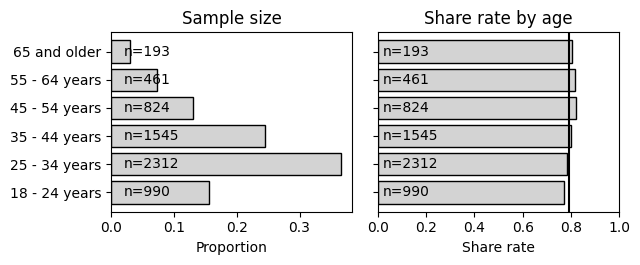

,age,n,share rate
0,18 - 24 years,990,0.773
1,25 - 34 years,2312,0.784
2,35 - 44 years,1545,0.801
3,45 - 54 years,824,0.820
4,55 - 64 years,461,0.818
5,65 and older,193,0.803


In [258]:
Q = 'q-demos-age'
print(fields_df.loc[Q][0])
age_df = df[Q].value_counts().rename('survey N').to_frame().sort_index()
age_df['survey proportion'] = age_df['survey N']/age_df['survey N'].sum()
figsize = (3.25, 2.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(age_df, axes[0])
axes[0].set_title('Sample size')
colname = 'age'
age_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(age_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
age_share_df

Test for interaction effects between age and experimental arms

In [260]:
print(Q)
formula = "share ~ C(age, Treatment(reference='35 - 44 years'))*showdata + C(incentive, Treatment(reference='control'))*C(age, Treatment(reference='35 - 44 years'))"
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

q-demos-age
Optimization terminated successfully.
         Current function value: 0.496688
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                            Results: Logit
======================================================================================================================================================================
Model:                                                 Logit                                             Pseudo R-squared:                                  0.019     
Dependent Variable:                                    share                                             AIC:                                               6183.2478 
Date:                                                  2023-05-24 18:01                                  BIC:                                               6425.3310 
No. Observations:                                      6152                                              Log-Likelihood:                                    -3055.6   
Df Model:                                              35                                                LL-Null:                                           -3115.0   
Df Residuals:                                          6116                                              LLR p-value:                                       4.8415e-11
Converged:                                             1.0000                                            Scale:                                             1.0000    
No. Iterations:                                        6.0000                                                                                                         
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                               1.3514   0.1631  8.2835 0.0000  1.0316  1.6711
C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]                                                          -0.5608   0.2396 -2.3401 0.0193 -1.0305 -0.0911
C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]                                                          -0.3559   0.2041 -1.7433 0.0813 -0.7560  0.0442
C(age, Treatment(reference='35 - 44 years'))[T.45 - 54 years]                                                          -0.2217   0.2580 -0.8595 0.3901 -0.7274  0.2839
C(age, Treatment(reference='35 - 44 years'))[T.55 - 64 years]                                                          -0.3369   0.3175 -1.0609 0.2887 -0.9593  0.2855
C(age, Treatment(reference='35 - 44 years'))[T.65 and older]                                                            0.3720   0.5251  0.7084 0.4787 -0.6572  1.4012
showdata[T.True]                                                                                                        0.3432   0.1313  2.6136 0.0090  0.0858  0.6007
C(incentive, Treatment(reference='control'))[T.altruism]                                                               -0.2324   0.2042 -1.1382 0.2550 -0.6327  0.1678
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                               -0.4028   0.2014 -2.0003 0.0455 -0.7974 -0.0081
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                               -0.1419   0.2081 -0.6817 0.4954 -0.5498  0.2660
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                                0.4996   0.2432  2.0541 0.0400  0.0229  0.9763
C(age, Treatment(re

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.351,3.863,"[2.806, 5.318]",0.000
"C(age, Treatment(reference='35 - 44 years'))[T.18 - 24 years]",-0.561,0.571,"[0.357, 0.913]",0.019
"C(age, Treatment(reference='35 - 44 years'))[T.25 - 34 years]",-0.356,0.701,"[0.470, 1.045]",0.081
"C(age, Treatment(reference='35 - 44 years'))[T.45 - 54 years]",-0.222,0.801,"[0.483, 1.328]",0.390
"C(age, Treatment(reference='35 - 44 years'))[T.55 - 64 years]",-0.337,0.714,"[0.383, 1.330]",0.289
"C(age, Treatment(reference='35 - 44 years'))[T.65 and older]",0.372,1.451,"[0.518, 4.060]",0.479
showdata[T.True],0.343,1.410,"[1.090, 1.823]",0.009
"C(incentive, Treatment(reference='control'))[T.altruism]",-0.232,0.793,"[0.531, 1.183]",0.255
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.403,0.668,"[0.450, 0.992]",0.045


#### Evaluate each incentive separately

q-demos-age


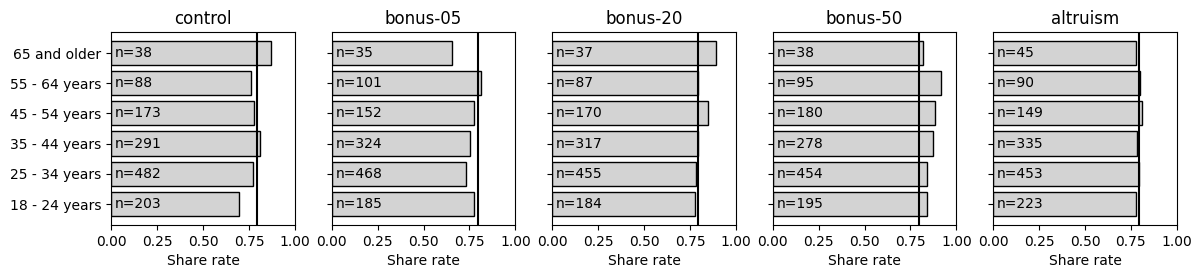

In [262]:
print(Q)
# formula = "share ~ C(age, Treatment(reference='35 - 44 years'))"
# print(formula)
figsize = (2.75, 2.5)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['age'] = incentive_df[Q]
#     print('------- %s -------' % incentive)
    age_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(age_share_df, colname, axes[i])
    axes[i].set_title(incentive)
#     model = smf.logit(formula=formula, data=incentive_df).fit()
#     display(model.summary2())
    #display(get_predictors_table(model))
    
plt.show()

#### Evaluating age groups separately

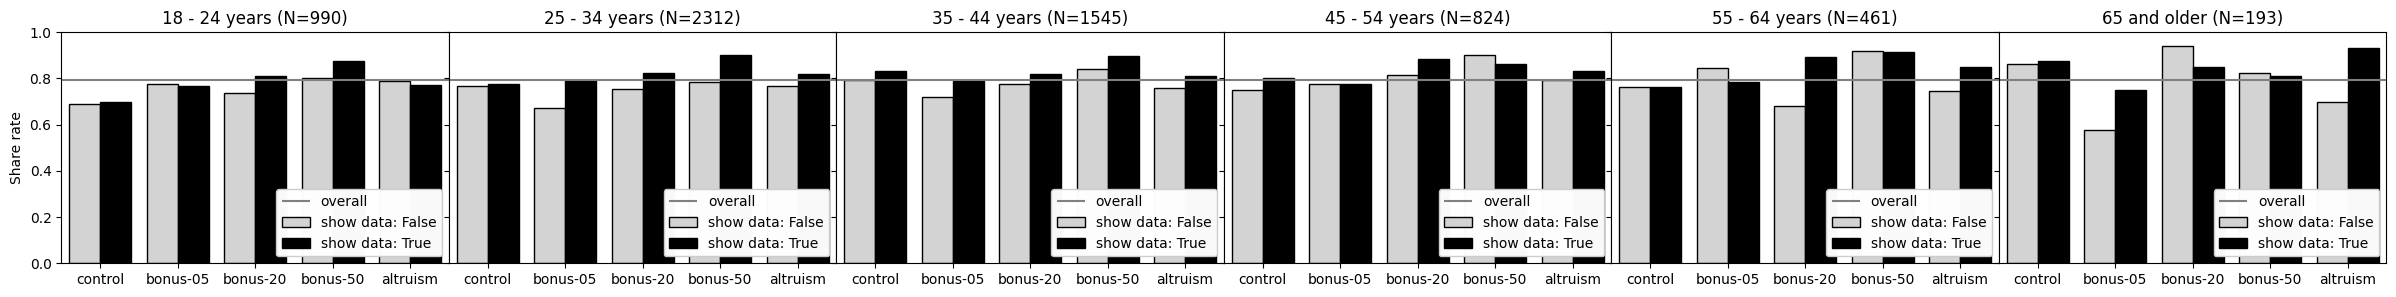

In [263]:
figsize=(5,3)
fig,axes = plt.subplots(1,6,figsize=(figsize[0]*6,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, age in enumerate(age_df.index.to_list()):
    demo_df = df[df[Q]==age]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (age, len(demo_df)))

### By education

In [264]:
education_order = ['Prefer not to say', 'Some high school or less', 'High school diploma or GED', 
                   "Bachelor's degree", 'Graduate or professional degree']

Overall

What is the highest level of education you have completed?


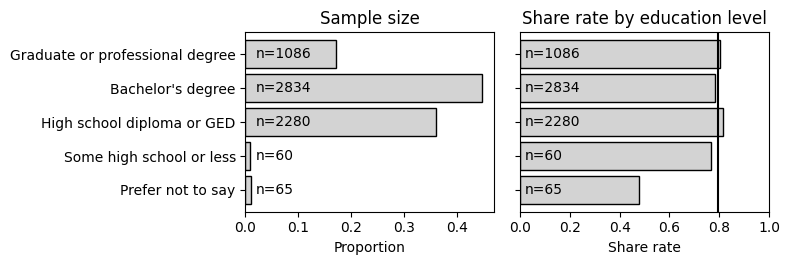

,education level,n,share rate
0,Prefer not to say,65,0.477
1,Some high school or less,60,0.767
2,High school diploma or GED,2280,0.816
3,Bachelor's degree,2834,0.781
4,Graduate or professional degree,1086,0.802


In [265]:
Q = 'Q-demos-education'
print(fields_df.loc[Q][0])
edu_df = df[Q].value_counts().rename('survey N').to_frame().loc[education_order] # sort by order defined
edu_df['survey proportion'] = edu_df['survey N']/edu_df['survey N'].sum()
figsize = (4, 2.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(edu_df, axes[0])
axes[0].set_title('Sample size')
colname = 'education level'
edu_share_df = get_share_rate_by_Q_df(Q, colname).set_index(colname).loc[education_order].reset_index()
plot_share_by_demo(edu_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
edu_share_df

#### Testing for interaction effects between education and experimental arms

In [266]:
formula = "share ~ showdata*C(edu) + C(incentive, Treatment(reference='control'))*C(edu)"
print(formula)
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())

share ~ showdata*C(edu) + C(incentive, Treatment(reference='control'))*C(edu)
         Current function value: 0.494678
         Iterations: 35


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                     Results: Logit
=========================================================================================================================================================
Model:                                            Logit                                         Pseudo R-squared:                              0.023     
Dependent Variable:                               share                                         AIC:                                           6146.5135 
Date:                                             2023-05-24 18:01                              BIC:                                           6348.2495 
No. Observations:                                 6152                                          Log-Likelihood:                                -3043.3   
Df Model:                                         29                                            LL-Null:                                       -3115.0   
Df Residuals:                                     6122                                          LLR p-value:                                   4.1977e-17
Converged:                                        0.0000                                        Scale:                                         1.0000    
No. Iterations:                                   35.0000                                                                                                
---------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                    Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
---------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                            1.0146    0.1074  9.4469 0.0000     0.8041    1.2251
showdata[T.True]                                                                                     0.3946    0.0932  4.2350 0.0000     0.2120    0.5772
C(edu)[T.Graduate or professional degree]                                                            0.1395    0.2075  0.6724 0.5014    -0.2671    0.5461
C(edu)[T.High school diploma or GED]                                                                 0.1558    0.1708  0.9121 0.3617    -0.1790    0.4905
C(edu)[T.Prefer not to say]                                                                         -1.5890    0.6000 -2.6483 0.0081    -2.7650   -0.4130
C(edu)[T.Some high school or less]                                                                  18.4732 4342.8721  0.0043 0.9966 -8493.3997 8530.3461
C(incentive, Treatment(reference='control'))[T.altruism]                                             0.0333    0.1420  0.2346 0.8145    -0.2450    0.3116
C(incentive, Treatment(reference='control'))[T.bonus-05]                                            -0.2347    0.1377 -1.7040 0.0884    -0.5046    0.0352
C(incentive, Treatment(reference='control'))[T.bonus-20]                                             0.1627    0.1451  1.1217 0.2620    -0.1216    0.4470
C(incentive, Treatment(reference='control'))[T.bonus-50]                                             0.5108    0.1559  3.2764 0.0011     0.2052    0.8164
showdata[T.True]:C(edu)[T.Graduate or professional degree]                                          -0.0200    0.1842 -0.1087 0.9134    -0.3811    0.3411
showdata[T.True]:C(edu)[T.High school diploma or GED]                                               -0.0995    0.1456 -0.6830 0.4946    -0.3849    0.1860
showdata[T.True]:C(edu)[T.Prefer not to say]                                                         0.0622    0.6183  0.1006 0.9199    -1.1497    1.2741
showdata[T.True]:

Model could not handle small group with odd distribution: some high school or less

So here we drop that group and run the model again.

In [267]:
formula = "share ~ showdata*C(edu) + C(incentive, Treatment(reference='control'))*C(edu)"
print(formula)
model = smf.logit(formula=formula, data=mdf[mdf['edu']!='Some high school or less']).fit()
display(model.summary2())

share ~ showdata*C(edu) + C(incentive, Treatment(reference='control'))*C(edu)
Optimization terminated successfully.
         Current function value: 0.495214
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                  Results: Logit
==================================================================================================================================================
Model:                                         Logit                                       Pseudo R-squared:                            0.021     
Dependent Variable:                            share                                       AIC:                                         6083.6680 
Date:                                          2023-05-24 18:02                            BIC:                                         6244.8295 
No. Observations:                              6094                                        Log-Likelihood:                              -3017.8   
Df Model:                                      23                                          LL-Null:                                     -3082.7   
Df Residuals:                                  6070                                        LLR p-value:                                 7.1490e-17
Converged:                                     1.0000                                      Scale:                                       1.0000    
No. Iterations:                                6.0000                                                                                             
--------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                           1.0146   0.1074  9.4469 0.0000  0.8041  1.2251
showdata[T.True]                                                                                    0.3946   0.0932  4.2350 0.0000  0.2120  0.5772
C(edu)[T.Graduate or professional degree]                                                           0.1395   0.2075  0.6724 0.5014 -0.2671  0.5461
C(edu)[T.High school diploma or GED]                                                                0.1558   0.1708  0.9121 0.3617 -0.1790  0.4905
C(edu)[T.Prefer not to say]                                                                        -1.5890   0.6000 -2.6483 0.0081 -2.7650 -0.4130
C(incentive, Treatment(reference='control'))[T.altruism]                                            0.0333   0.1420  0.2346 0.8145 -0.2450  0.3116
C(incentive, Treatment(reference='control'))[T.bonus-05]                                           -0.2347   0.1377 -1.7040 0.0884 -0.5046  0.0352
C(incentive, Treatment(reference='control'))[T.bonus-20]                                            0.1627   0.1451  1.1217 0.2620 -0.1216  0.4470
C(incentive, Treatment(reference='control'))[T.bonus-50]                                            0.5108   0.1559  3.2764 0.0011  0.2052  0.8164
showdata[T.True]:C(edu)[T.Graduate or professional degree]                                         -0.0200   0.1842 -0.1087 0.9134 -0.3811  0.3411
showdata[T.True]:C(edu)[T.High school diploma or GED]                                              -0.0995   0.1456 -0.6830 0.4946 -0.3849  0.1860
showdata[T.True]:C(edu)[T.Prefer not to say]                                                        0.0622   0.6183  0.1006 0.9199 -1.1497  1.2741
C(incentive, Treatment(reference='control'))[T.altruism]:C(edu)[T.Graduate or professional degree]  0.1981   0.2801  0.7073 0.4794 -0.3509  0.7471
C(incentive, Treatment(reference='control'))[T.bonus-05]:C(edu)[T.Graduate or professional degree] -0.0035   0.2652 -0.0131 0.9895 -0.5232  0.5163
C(incentive, Treatment(reference='control'))[T.b

#### Evaluate each incentive separately

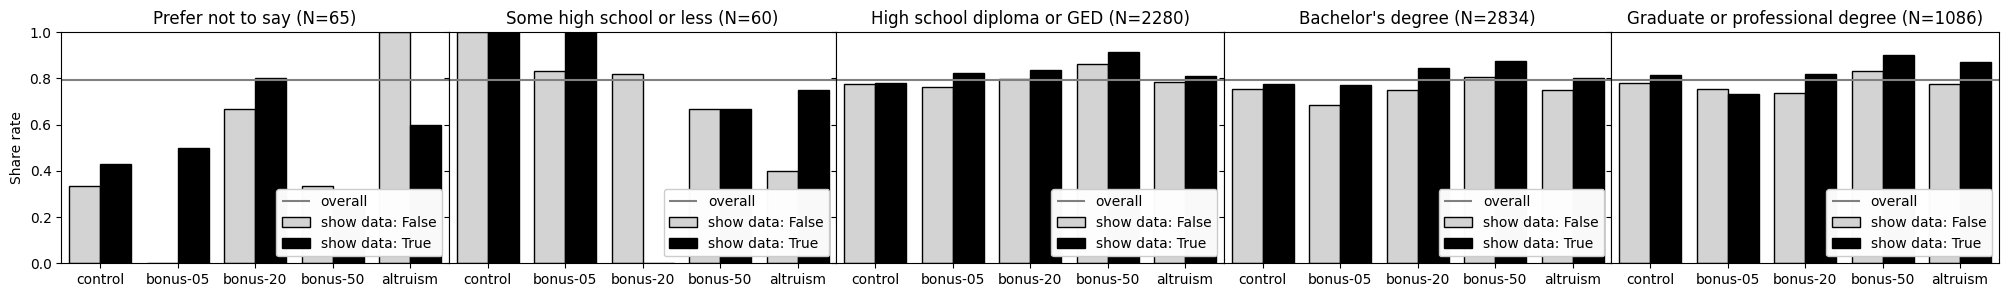

In [268]:
figsize=(5,3)
fig,axes = plt.subplots(1,5,figsize=(figsize[0]*5,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, edu in enumerate(education_order):
    demo_df = df[df[Q]==edu]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (edu, len(demo_df)))

### By sexual orientation

Overall

Which best describes your sexual orientation?


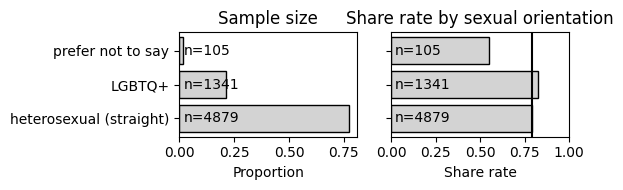

,sexual orientation,n,share rate
0,LGBTQ+,1341,0.828
1,heterosexual (straight),4879,0.790
2,prefer not to say,105,0.552


In [269]:
Q = 'Q-sexual-orientation'
print(fields_df.loc[Q][0])
so_df = df[Q].value_counts().rename('survey N').to_frame()
so_df['survey proportion'] = so_df['survey N']/so_df['survey N'].sum()
figsize = (3, 2)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(so_df, axes[0])
axes[0].set_title('Sample size')
colname = 'sexual orientation'
so_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(so_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
so_share_df

#### Testing for interaction effects between sexual orientation and experimental arms

In [270]:
formula = "share ~ showdata*C(lgbtq_status, Treatment(reference='heterosexual (straight)')) + C(incentive, Treatment(reference='control'))*C(lgbtq_status, Treatment(reference='heterosexual (straight)'))"
print(formula)
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())

share ~ showdata*C(lgbtq_status, Treatment(reference='heterosexual (straight)')) + C(incentive, Treatment(reference='control'))*C(lgbtq_status, Treatment(reference='heterosexual (straight)'))
Optimization terminated successfully.
         Current function value: 0.496607
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                                       Results: Logit
============================================================================================================================================================================================
Model:                                                       Logit                                                     Pseudo R-squared:                                          0.019     
Dependent Variable:                                          share                                                     AIC:                                                       6146.2586 
Date:                                                        2023-05-24 18:02                                          BIC:                                                       6267.3002 
No. Observations:                                            6152                                                      Log-Likelihood:                                            -3055.1   
Df Model:                                                    17                                                        LL-Null:                                                   -3115.0   
Df Residuals:                                                6134                                                      LLR p-value:                                               1.7370e-17
Converged:                                                   1.0000                                                    Scale:                                                     1.0000    
No. Iterations:                                              6.0000                                                                                                                         
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                               Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                                      1.0186   0.0822 12.3989 0.0000  0.8576 1.1796
showdata[T.True]                                                                                                                               0.3494   0.0714  4.8902 0.0000  0.2094 0.4894
C(lgbtq_status, Treatment(reference='heterosexual (straight)'))[T.LGBTQ+]                                                                      0.3981   0.2044  1.9473 0.0515 -0.0026 0.7987
C(lgbtq_status, Treatment(reference='heterosexual (straight)'))[T.prefer not to say]                                                          -0.8943   0.5209 -1.7169 0.0860 -1.9152 0.1266
C(incentive, Treatment(reference='control'))[T.altruism]                                                                                       0.1141   0.1086  1.0499 0.2938 -0.0989 0.3270
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                                                      -0.1273   0.1051 -1.2111 0.2259 -0.3334 0.0787
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                                                       0.2111   0.1105  1.9108 0.0560 -0.0054 0.4277
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                                                       0.6376   0.1205  5.2933 0.0000  0.4015 0.8737
showdata[T.True]:C(lgbtq_status, Treatment(reference='heterosexual (s

#### Evaluate each incentive separately

Q-sexual-orientation


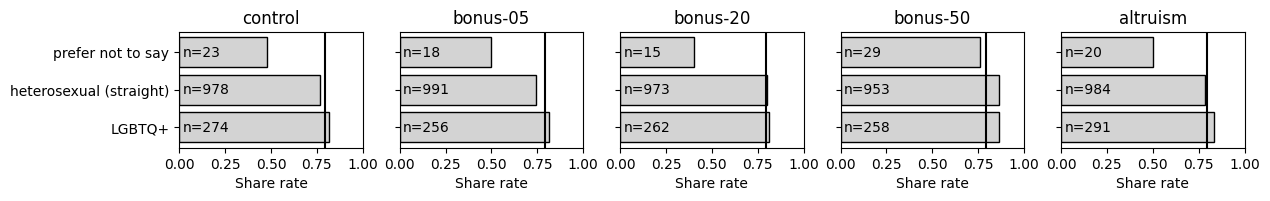

In [271]:
print(Q)
figsize = (2.75, 1.5)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['lgbtq_status'] = incentive_df[Q]
    so_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(so_share_df, colname, axes[i])
    axes[i].set_title(incentive)
    
plt.show()

### By race and hispanic origin

Note the US census and this survey ask about hispanic/latin origin in a question separate from race.

#### Spanish, Hispanic, or Latino origin

Overall

Are you of Spanish, Hispanic, or Latino origin?


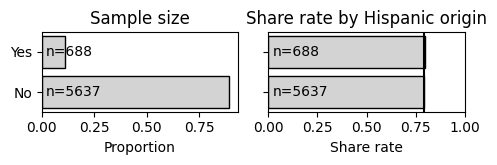

,Hispanic origin,n,share rate
0,No,5637,0.793
1,Yes,688,0.799


In [272]:
Q = 'Q-demos-hispanic'
print(fields_df.loc[Q][0])
hisp_df = df[Q].value_counts().rename('survey N').to_frame()
hisp_df['survey proportion'] = hisp_df['survey N']/hisp_df['survey N'].sum()
figsize = (2.5, 1.75)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(hisp_df, axes[0])
axes[0].set_title('Sample size')
colname = 'Hispanic origin'
hisp_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(hisp_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
hisp_share_df

Regression: testing for interaction effects

In [273]:
formula = "share ~ showdata*C(hispanic, Treatment(reference='No')) + C(incentive, Treatment(reference='control'))*C(hispanic, Treatment(reference='No'))"
print(formula)
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())

share ~ showdata*C(hispanic, Treatment(reference='No')) + C(incentive, Treatment(reference='control'))*C(hispanic, Treatment(reference='No'))
Optimization terminated successfully.
         Current function value: 0.499239
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                   Results: Logit
=====================================================================================================================================================
Model:                                          Logit                                        Pseudo R-squared:                             0.014     
Dependent Variable:                             share                                        AIC:                                          6166.6409 
Date:                                           2023-05-24 18:02                             BIC:                                          6247.3353 
No. Observations:                               6152                                         Log-Likelihood:                               -3071.3   
Df Model:                                       11                                           LL-Null:                                      -3115.0   
Df Residuals:                                   6140                                         LLR p-value:                                  5.5094e-14
Converged:                                      1.0000                                       Scale:                                        1.0000    
No. Iterations:                                 6.0000                                                                                               
-----------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                               1.0897   0.0788 13.8257 0.0000  0.9352 1.2442
showdata[T.True]                                                                                        0.3512   0.0678  5.1779 0.0000  0.2183 0.4841
C(hispanic, Treatment(reference='No'))[T.Yes]                                                          -0.1317   0.2347 -0.5614 0.5745 -0.5917 0.3282
C(incentive, Treatment(reference='control'))[T.altruism]                                                0.0673   0.1036  0.6498 0.5158 -0.1357 0.2704
C(incentive, Treatment(reference='control'))[T.bonus-05]                                               -0.1353   0.1011 -1.3383 0.1808 -0.3334 0.0628
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                0.1213   0.1048  1.1579 0.2469 -0.0840 0.3266
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                0.5495   0.1137  4.8312 0.0000  0.3266 0.7725
showdata[T.True]:C(hispanic, Treatment(reference='No'))[T.Yes]                                         -0.0414   0.2090 -0.1978 0.8432 -0.4511 0.3684
C(incentive, Treatment(reference='control'))[T.altruism]:C(hispanic, Treatment(reference='No'))[T.Yes]  0.2597   0.3057  0.8497 0.3955 -0.3394 0.8589
C(incentive, Treatment(reference='control'))[T.bonus-05]:C(hispanic, Treatment(reference='No'))[T.Yes]  0.0633   0.2971  0.2131 0.8313 -0.5191 0.6457
C(incentive, Treatment(reference='control'))[T.bonus-20]:C(hispanic, Treatment(reference='No'))[T.Yes]  0.1890   0.3197  0.5911 0.5545 -0.4376 0.8156
C(incentive, Treatment(reference='control'))[T.bonus-50]:C(hispanic, Treatment(reference='No'))[T.Yes]  0.6333   0.3903  1.6226 0.1047 -0.1317 1.3983
=====================================================================================================================================================

"""

#### Evaluate each incentive separately

Q-demos-hispanic


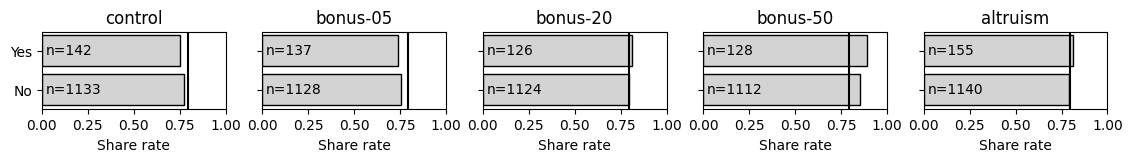

In [274]:
print(Q)
figsize = (2.75, 1)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['hispanic'] = incentive_df[Q]
    hisp_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(hisp_share_df, colname, axes[i])
    axes[i].set_title(incentive)
    
plt.show()

#### Evaluating Hispanic vs non-Hispanic groups separately

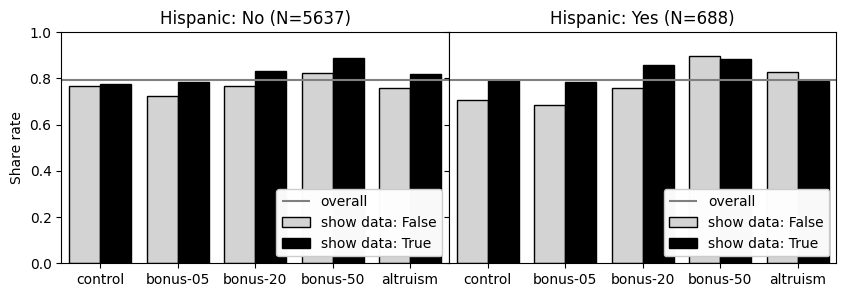

In [275]:
figsize=(5,3)
fig,axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, hisp in enumerate(hisp_df.index.to_list()):
    demo_df = df[df[Q]==hisp]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('Hispanic: %s (N=%s)' % (hisp, len(demo_df)))

### Race

In [276]:
Q = 'Q-demos-race'
print(fields_df.loc[Q][0])
race_df = df[Q].value_counts().rename('survey N').to_frame()
race_df['survey proportion'] = round(race_df['survey N']/race_df['survey N'].sum(), 3)
race_df.head(10)

Choose one or more races that you consider yourself to be


,survey N,survey proportion
Q-demos-race,,
White or Caucasian,4825,0.763
Asian,551,0.087
Black or African American,440,0.070
Other,134,0.021
"White or Caucasian,Asian",96,0.015
"White or Caucasian,Black or African American",72,0.011
"White or Caucasian,American Indian/Native American or Alaska Native",66,0.010
American Indian/Native American or Alaska Native,38,0.006
"White or Caucasian,Other",32,0.005


For simplicity we aggregate 'Other' + anyone who answered 2 more more races + anyone with 'American Indian'

Including 'American Indian' in this aggregation because otherwise this group is too small.

Note this is very simplifying.

In [288]:
df['race'] = df[Q].apply(lambda r: 'Other or 2 or more races' if ((len(r.split(',')) > 1) or ('Other' in r) or ('American Indian' in r)) else r)
race_df = df['race'].value_counts().rename('survey N').to_frame()
race_df['survey proportion'] = round(race_df['survey N']/race_df['survey N'].sum(), 3)
race_df.head(10)

,survey N,survey proportion
race,,
White or Caucasian,4825,0.763
Asian,551,0.087
Other or 2 or more races,509,0.080
Black or African American,440,0.070


Overall

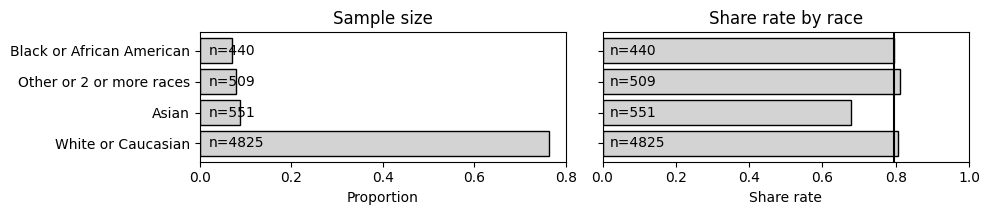

,race,n,share rate
0,Asian,551,0.679
1,Black or African American,440,0.795
2,Other or 2 or more races,509,0.811
3,White or Caucasian,4825,0.805


In [289]:
figsize = (5, 2.25)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(race_df, axes[0])
axes[0].set_title('Sample size')
colname = 'race'
race_share_df = get_share_rate_by_Q_df('race', colname)
plot_share_by_demo(race_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
race_share_df

Test for interaction effects between race and experimental arms

In [290]:
print(Q)
formula = "share ~ showdata*C(race, Treatment(reference='White or Caucasian')) + C(incentive, Treatment(reference='control'))*C(race, Treatment(reference='White or Caucasian'))"
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
# display(get_predictors_table(model))

Q-demos-race
Optimization terminated successfully.
         Current function value: 0.495197
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                                     Results: Logit
========================================================================================================================================================================================
Model:                                                       Logit                                                   Pseudo R-squared:                                        0.022     
Dependent Variable:                                          share                                                   AIC:                                                     6140.9033 
Date:                                                        2023-05-24 18:09                                        BIC:                                                     6302.2920 
No. Observations:                                            6152                                                    Log-Likelihood:                                          -3046.5   
Df Model:                                                    23                                                      LL-Null:                                                 -3115.0   
Df Residuals:                                                6128                                                    LLR p-value:                                             3.2027e-18
Converged:                                                   1.0000                                                  Scale:                                                   1.0000    
No. Iterations:                                              6.0000                                                                                                                     
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                                                 1.1259   0.0865 13.0105 0.0000  0.9563  1.2955
showdata[T.True]                                                                                                                          0.3517   0.0750  4.6880 0.0000  0.2047  0.4988
C(race, Treatment(reference='White or Caucasian'))[T.Asian]                                                                              -0.5669   0.2397 -2.3648 0.0180 -1.0367 -0.0970
C(race, Treatment(reference='White or Caucasian'))[T.Black or African American]                                                           0.0049   0.2898  0.0168 0.9866 -0.5631  0.5729
C(race, Treatment(reference='White or Caucasian'))[T.Other or 2 or more races]                                                            0.0690   0.2826  0.2442 0.8071 -0.4850  0.6230
C(incentive, Treatment(reference='control'))[T.altruism]                                                                                  0.1027   0.1136  0.9041 0.3659 -0.1199  0.3254
C(incentive, Treatment(reference='control'))[T.bonus-05]                                                                                 -0.1522   0.1099 -1.3849 0.1661 -0.3675  0.0632
C(incentive, Treatment(reference='control'))[T.bonus-20]                                                                                  0.1979   0.1162  1.7028 0.0886 -0.0299  0.4257
C(incentive, Treatment(reference='control'))[T.bonus-50]                                                                                  0.6946   0.12

#### Evaluate each incentive separately

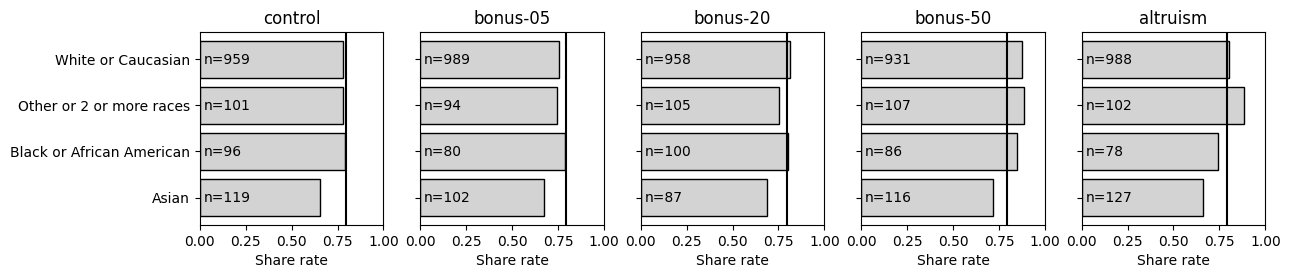

In [292]:
# formula = "share ~ C(race, Treatment(reference='White or Caucasian'))"
# print(formula)
figsize = (2.75, 2.5)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
#     print('------- %s -------' % incentive)
    race_share_df = get_share_rate_by_Q_df('race', colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(race_share_df, colname, axes[i])
    axes[i].set_title(incentive)
#     model = smf.logit(formula=formula, data=incentive_df).fit()
#     display(model.summary2())
    #display(get_predictors_table(model))
    
plt.show()

#### Evaluating by racial groups separately

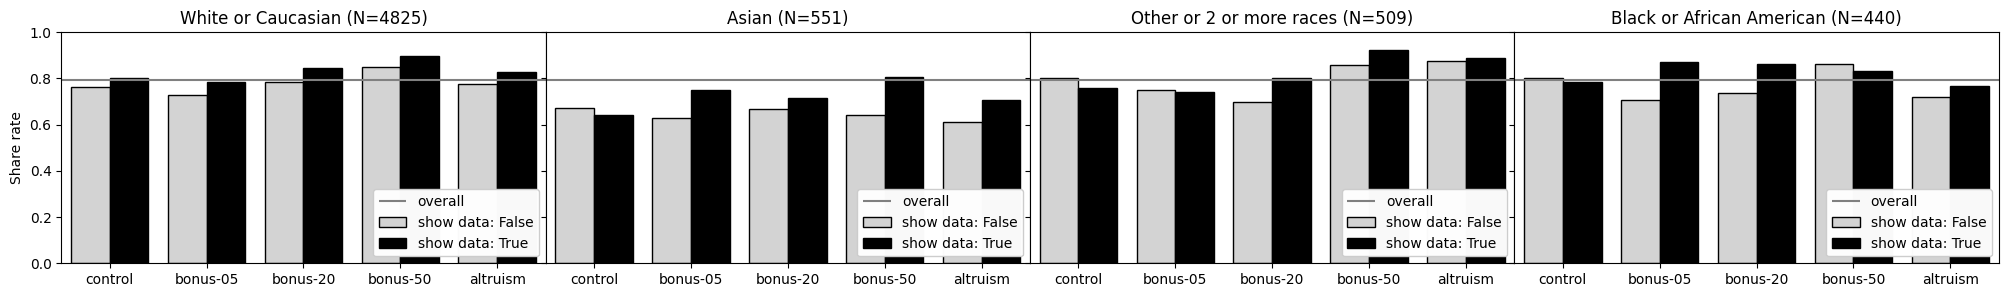

In [295]:
figsize=(5,3)
fig,axes = plt.subplots(1,4,figsize=(figsize[0]*5,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, race in enumerate(race_df.index.to_list()):
    demo_df = df[df['race']==race]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (race.split('/')[0], len(demo_df)))

In [294]:
# # Logistic reggressions to test for differences
# formula = "share ~ C(incentive, Treatment(reference='control')) + showdata"
# for i, race in enumerate(race_df.index.to_list()):
#     if 'American Indian' in race: # Group too small
#         continue
#     print('------- race group: %s -------' % race)
#     print(formula)
#     demo_df = df[df['race']==race]
#     model = smf.logit(formula=formula, data=demo_df).fit()
#     display(model.summary2())
#     #display(get_predictors_table(model))

### By purchase frequency

How often do you (+ anyone you share your account with) order deliveries from Amazon?


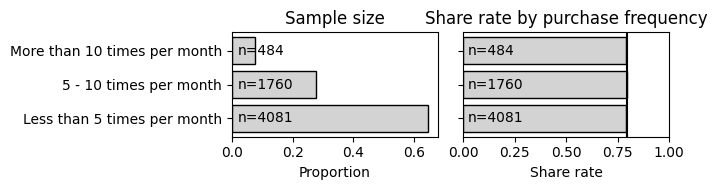

,purchase frequency,n,share rate
0,5 - 10 times per month,1760,0.798
1,Less than 5 times per month,4081,0.793
2,More than 10 times per month,484,0.789


In [297]:
Q = 'Q-amazon-use-how-oft'
print(fields_df.loc[Q][0])
pf_df = df[Q].value_counts().rename('survey N').to_frame()
pf_df['survey proportion'] = pf_df['survey N']/pf_df['survey N'].sum()
figsize = (3.5, 2)
fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
plt.tight_layout()
plot_survey_proportion_with_N(pf_df, axes[0])
axes[0].set_title('Sample size')
colname = 'purchase frequency'
pf_share_df = get_share_rate_by_Q_df(Q, colname)
plot_share_by_demo(pf_share_df, colname, axes[1])
plt.tight_layout()
plt.show()
pf_share_df

#### Evaluate each incentive separately

Q-amazon-use-how-oft


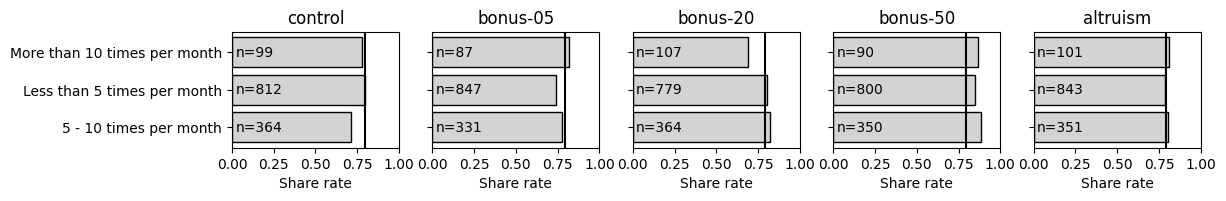

In [298]:
print(Q)
# formula = "share ~ C(frequency)"
# print(formula)
figsize = (2.5, 1.5)
# plot horizontally all together
fig, axes = plt.subplots(1,5,figsize=(figsize[0]*5, figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0.2)
for i, incentive in enumerate(incentives_list):
    # restrict data to incentive
    incentive_df = df[df['incentive']==incentive].copy()
    # give demo a short name from Q
    incentive_df['frequency'] = incentive_df[Q]
#     print('------- %s -------' % incentive)
    pf_share_df = get_share_rate_by_Q_df(Q, colname, df=incentive_df)
    # plot horizontally with the others
    plot_share_by_demo(pf_share_df, colname, axes[i])
    axes[i].set_title(incentive)
#     model = smf.logit(formula=formula, data=incentive_df).fit()
#     display(model.summary2())
#     if incentive == 'control':
#         display(get_predictors_table(model))  
plt.show()

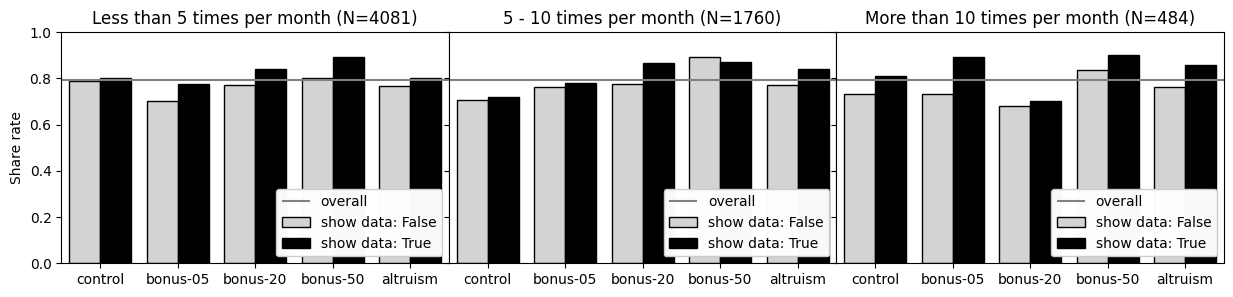

In [299]:
figsize=(5,3)
fig,axes = plt.subplots(1,3,figsize=(figsize[0]*3,figsize[1]), sharey=True)
plt.subplots_adjust(wspace=0)
for i, pf in enumerate(pf_df.index.to_list()):
    demo_df = df[df[Q]==pf]
    demo_agg_share_df = get_aggregate_share_df(demo_df)
    plot_share_rate(demo_agg_share_df, axes[i])
    axes[i].set_title('%s (N=%s)' % (pf, len(demo_df)))

Test for interaction effects

In [303]:
print(Q)
print(fields_df.loc[Q][0],'\n')
formula = "share ~ showdata*C(frequency) + C(incentive, Treatment(reference='control'))*C(frequency)"
model = smf.logit(formula=formula, data=mdf).fit()
display(model.summary2())
display(get_predictors_table(model))

Q-amazon-use-how-oft
How often do you (+ anyone you share your account with) order deliveries from Amazon? 

Optimization terminated successfully.
         Current function value: 0.497426
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                   Results: Logit
=====================================================================================================================================================
Model:                                          Logit                                        Pseudo R-squared:                             0.018     
Dependent Variable:                             share                                        AIC:                                          6156.3353 
Date:                                           2023-05-25 09:50                             BIC:                                          6277.3769 
No. Observations:                               6152                                         Log-Likelihood:                               -3060.2   
Df Model:                                       17                                           LL-Null:                                      -3115.0   
Df Residuals:                                   6134                                         LLR p-value:                                  1.4031e-15
Converged:                                      1.0000                                       Scale:                                        1.0000    
No. Iterations:                                 6.0000                                                                                               
-----------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              0.8272   0.1317  6.2803 0.0000  0.5690  1.0853
showdata[T.True]                                                                                       0.2475   0.1227  2.0177 0.0436  0.0071  0.4879
C(frequency)[T.Less than 5 times per month]                                                            0.3845   0.1630  2.3589 0.0183  0.0650  0.7039
C(frequency)[T.More than 10 times per month]                                                           0.1425   0.3007  0.4737 0.6357 -0.4469  0.7319
C(incentive, Treatment(reference='control'))[T.altruism]                                               0.4592   0.1802  2.5485 0.0108  0.1060  0.8124
C(incentive, Treatment(reference='control'))[T.bonus-05]                                               0.2962   0.1782  1.6622 0.0965 -0.0531  0.6456
C(incentive, Treatment(reference='control'))[T.bonus-20]                                               0.5740   0.1822  3.1499 0.0016  0.2169  0.9312
C(incentive, Treatment(reference='control'))[T.bonus-50]                                               1.0873   0.2060  5.2781 0.0000  0.6836  1.4911
showdata[T.True]:C(frequency)[T.Less than 5 times per month]                                           0.1293   0.1464  0.8831 0.3772 -0.1577  0.4163
showdata[T.True]:C(frequency)[T.More than 10 times per month]                                          0.2661   0.2595  1.0253 0.3052 -0.2426  0.7747
C(incentive, Treatment(reference='control'))[T.altruism]:C(frequency)[T.Less than 5 times per month]  -0.5574   0.2186 -2.5504 0.0108 -0.9857 -0.1290
C(incentive, Treatment(reference='control'))[T.bonus-05]:C(frequency)[T.Less than 5 times per month]  -0.6581   0.2147 -3.0658 0.0022 -1.0788 -0.2374
C(incentive, Treatment(reference='control'))[T.bonus-20]:C(frequency)[T.Less than 5 times per month]  -0.5475   0.2227 -2.4580 0.0140 -0.9841 -0.1109
C(incentive, Treatment(reference='control'))[T.bonus-50]:C(frequency)[T.Less than 5 times per month]  -0.7140   0.2469 

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.827,2.287,"[1.767, 2.960]",0.000
showdata[T.True],0.247,1.281,"[1.007, 1.629]",0.044
C(frequency)[T.Less than 5 times per month],0.384,1.469,"[1.067, 2.022]",0.018
C(frequency)[T.More than 10 times per month],0.142,1.153,"[0.640, 2.079]",0.636
"C(incentive, Treatment(reference='control'))[T.altruism]",0.459,1.583,"[1.112, 2.253]",0.011
"C(incentive, Treatment(reference='control'))[T.bonus-05]",0.296,1.345,"[0.948, 1.907]",0.096
"C(incentive, Treatment(reference='control'))[T.bonus-20]",0.574,1.775,"[1.242, 2.538]",0.002
"C(incentive, Treatment(reference='control'))[T.bonus-50]",1.087,2.966,"[1.981, 4.442]",0.000
showdata[T.True]:C(frequency)[T.Less than 5 times per month],0.129,1.138,"[0.854, 1.516]",0.377


## Monetary value of data: Real vs hypothetical impact of bonus incentive

On average, how does the hypothetical amount of money participants say they would accept in exchange for their data compare to the amount that participants do accept as bonus payment for their data, when presented with the real opportunity? 

Given our results were only significant from control at the bonus:$0.50 level, we focus on this.


#### Analysis method 1:


Measure the difference between


Real share rate increase due to $0.50 bonus
- = (bonus50_share_rate_real - control_share_rate)

vs

Hypothetical share rate increase due to \\$0.50 bonus 




Measure real share rate increase as 
(bonus50_share_rate_real - control_share_rate)

Where: 
- *control_share_rate*: share rate in the control arm (portion shared with no extra bonus incentive)
- *bonus50_share_rate_real* share rate for the bonus:0.50 incentive arm
    - We interpret this as the portion of people who would share data for a (real) bonus amount of 0.50 or less


Measure hypothetical share rate increase as:
portion of participants in the control arm who did not share their data but answered yes
they would hypothetically share their data for a bonus payment of 0.50 or less. 

i.e. for hypotehtical share rate increase:
- restrict data to participants in control arm AND answered no share
- measure rate they answered they would hypothetically share for any of \\$0.05, \\$0.20, \\$0.50


We also compute these measures for each bonus amount and make plots.

Done for showdata=True/False separately.


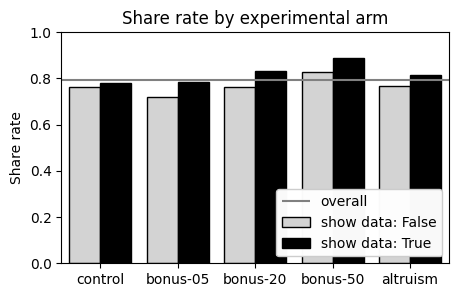

,incentive,showdata,count,mean
0,control,False,636,0.763
1,control,True,639,0.779
2,bonus-05,False,647,0.720
3,bonus-05,True,618,0.785
4,bonus-20,False,648,0.765
5,bonus-20,True,602,0.834
6,bonus-50,False,624,0.830
7,bonus-50,True,616,0.888
8,altruism,False,653,0.767
9,altruism,True,642,0.816


In [74]:
fig,ax = plt.subplots(1,1, figsize=(5,3))#, dpi=300)
ax.set_title('Share rate by experimental arm')
plot_share_rate(agg_share_df, ax)
plt.show()
agg_share_df

Compute "real" share rate increases using share rate (`mean`) above.

For showdata=True/False separately. And overall.

In [75]:
def get_share_rate_change(agg_df):
    sdf = (agg_df.set_index('incentive').loc[['control','bonus-05','bonus-20','bonus-50']])['mean'].rename(
        {'control':'$0', 'bonus-05':'$0.05', 'bonus-20':'$0.20', 'bonus-50':'$0.50'}
    )
    return sdf - sdf.loc['$0']

print('share rate change for showdata=True:')
real_share_rate_change_showdata_true = get_share_rate_change(agg_share_df[agg_share_df['showdata']==True])
print(real_share_rate_change_showdata_true)

print('\nshare rate change for showdata=False:')
real_share_rate_change_showdata_false = get_share_rate_change(agg_share_df[agg_share_df['showdata']==False])
print(real_share_rate_change_showdata_false)

share rate change for showdata=True:
incentive
$0       0.000
$0.05    0.006
$0.20    0.055
$0.50    0.109
Name: mean, dtype: float64

share rate change for showdata=False:
incentive
$0       0.000
$0.05   -0.043
$0.20    0.002
$0.50    0.067
Name: mean, dtype: float64


In [76]:
# Compute real share rate increase for total
agg_share_overall_df = (
    df.groupby(['incentive'])['share'].agg(['count','mean']).round(3)
    .reset_index().set_index('incentive').loc[incentives_list].reset_index()
)
display(agg_share_overall_df)
print('\nshare rate change overall:')
real_share_rate_change_overall = get_share_rate_change(agg_share_overall_df)
print(real_share_rate_change_overall)

,incentive,count,mean
0,control,1275,0.771
1,bonus-05,1265,0.752
2,bonus-20,1250,0.798
3,bonus-50,1240,0.859
4,altruism,1295,0.792



share rate change overall:
incentive
$0       0.000
$0.05   -0.019
$0.20    0.027
$0.50    0.088
Name: mean, dtype: float64


Compute hypothetical share rate increases.


Compute new tables, separately for showdata=True/False with the following
- restrict data to participants in control arm who answered no share
- restrict data to showdata=True/False
- this provides the 'total count'
- `share count`: count the number of answers for yes: hypothetically share for each hypothetical bonus
- `cumulative share count`: cumulative sum of share count
- `cumulative share rate`: `cumulative share count` / `total count` : represents increase in portino of people who would not share for \\$0 but would share for `amount` or less

Resulting table:

```
amount, total count, share count, cumulative share count, cumulative share rate
```

In [77]:
# data value Qs
hypo_bonus_Qs = [
    'Q-data-value-05','Q-data-value-20', 'Q-data-value-50', 
    'Q-data-value-100', 'Q-data-value-any', 'Q-data-value-any_1_TEXT'
]
# setting up hypo share df with all incentives first to reuse later for alternative method
hypo_shares_all_incentives = df[df['share']==0][['incentive', 'share', 'showdata']+hypo_bonus_Qs].fillna(0)

print(len(hypo_shares_all_incentives))

# Map the No/yes data value questions to 0/1
for col in ['Q-data-value-05','Q-data-value-20', 'Q-data-value-50', 'Q-data-value-100', 'Q-data-value-any']:
    hypo_shares_all_incentives[col] = hypo_shares_all_incentives[col].apply(lambda v: 0 if (v=='No' or v==0) else 1)
hypo_shares_all_incentives.head(3)

1303


,incentive,share,showdata,Q-data-value-05,Q-data-value-20,Q-data-value-50,Q-data-value-100,Q-data-value-any,Q-data-value-any_1_TEXT
1,bonus-05,0,False,0,0,0,1,0,0
8,control,0,False,0,0,0,0,1,1000.00
10,bonus-50,0,False,0,0,0,0,1,10


In [78]:
hypo_share_df = hypo_shares_all_incentives[hypo_shares_all_incentives['incentive']=='control']
print(len(hypo_share_df))
hypo_share_df.head()

292


,incentive,share,showdata,Q-data-value-05,Q-data-value-20,Q-data-value-50,Q-data-value-100,Q-data-value-any,Q-data-value-any_1_TEXT
8,control,0,False,0,0,0,0,1,1000.00
39,control,0,True,0,0,0,0,1,30.00
76,control,0,True,0,0,0,0,1,50
99,control,0,False,0,1,0,0,0,0
146,control,0,True,0,0,1,0,0,0


In [79]:
def get_hypo_share_rate_change(hypo_share_df):
#     s = hypo_share_df[(hypo_share_df['showdata']==False)][[
    s = hypo_share_df[[
        'share',
        'Q-data-value-05','Q-data-value-20', 'Q-data-value-50', 
        'Q-data-value-100', 'Q-data-value-any'
    ]]
    total_count = len(s)
    # rename columns to represent amounts offered
    s.columns=['$0','$0.05','$0.20','$0.50','$1.00','> $1.00']
    s = s.apply(sum).to_frame(name='share count')
    s.index.names = ['amount']
    s['total count'] = total_count
    s['cumulative count'] = s['share count'].cumsum()
    s['cumulative share rate'] = (
        s['cumulative count']/s['total count']
    ).round(3)
    return s

hypo_share_rate_change_overall = get_hypo_share_rate_change(hypo_share_df)
hypo_share_rate_change_overall

,share count,total count,cumulative count,cumulative share rate
amount,,,,
$0,0,292,0,0.000
$0.05,29,292,29,0.099
$0.20,5,292,34,0.116
$0.50,10,292,44,0.151
$1.00,26,292,70,0.240
> $1.00,221,292,291,0.997


In [80]:
hypo_share_rate_change_showdata_false = get_hypo_share_rate_change(hypo_share_df[hypo_share_df['showdata']==False])
print('hypothetical increase in share rate for showdata: False')
hypo_share_rate_change_showdata_false

hypothetical increase in share rate for showdata: False


,share count,total count,cumulative count,cumulative share rate
amount,,,,
$0,0,151,0,0.000
$0.05,12,151,12,0.079
$0.20,2,151,14,0.093
$0.50,5,151,19,0.126
$1.00,16,151,35,0.232
> $1.00,115,151,150,0.993


In [81]:
hypo_share_rate_change_showdata_true = get_hypo_share_rate_change(hypo_share_df[hypo_share_df['showdata']==True])
print('hypothetical increase in share rate for showdata: True')

hypo_share_rate_change_showdata_true

hypothetical increase in share rate for showdata: True


,share count,total count,cumulative count,cumulative share rate
amount,,,,
$0,0,141,0,0.000
$0.05,17,141,17,0.121
$0.20,3,141,20,0.142
$0.50,5,141,25,0.177
$1.00,10,141,35,0.248
> $1.00,106,141,141,1.000


Plot

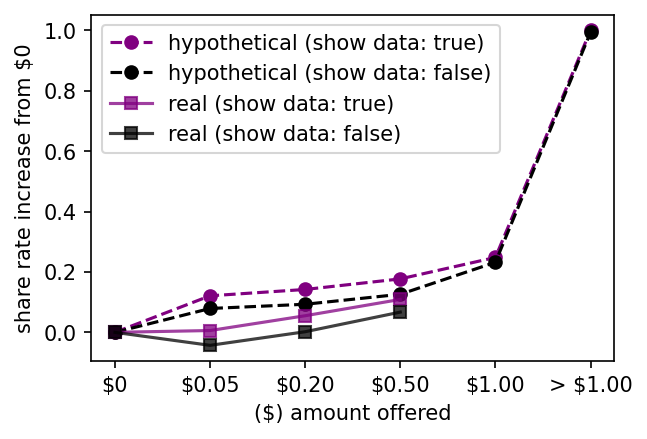

In [82]:
alpha = 0.75
fig,ax = plt.subplots(1,1, figsize=(4.5,3), dpi=150)
# showdata:true
ax.plot(hypo_share_rate_change_showdata_true['cumulative share rate'], 
        'o--', 
        color='purple', markersize=6,
       label='hypothetical (show data: true)')
ax.plot(hypo_share_rate_change_showdata_false['cumulative share rate'], 
        'o--', 
        color='black', markersize=6,
       label='hypothetical (show data: false)')
ax.plot(real_share_rate_change_showdata_true, 
        's-', 
        alpha=alpha,
        color='purple', markersize=6,
       label='real (show data: true)')

ax.plot(real_share_rate_change_showdata_false, 
        's-', 
        alpha=alpha,
        color='black', markersize=6,
       label='real (show data: false)')
#ax.set_ylim([0,1])
ax.set_ylabel('share rate increase from $0')
ax.set_xlabel('($) amount offered')
_ = ax.legend()

Observations:

- should expect the hypotehtical \$0.05 share rate to be higher since it can only increase vs we know in the real data that it was a lower share rate vs control
- consistent in both hypothetical and real data: share rate higher for showdata:true, and the difference between showdata:true vs showdata:false is consistent
- this is the case until the hypothetical bonus is $1 or more at which point there is negligible difference between showdata:true vs false
- almost all will hypothetically share data for some amount when they can name their own price

#### Analysis method 2

Computer real impact of $0.50 as:

- (share_rate_bonus50 - share_rate_bonus20)

Vs


Hypothetical impact:
- Restrict to incentive:bonus20 & no share
- Use rate of share for hypothetical bonus50

Similarly for the other amounts


In [83]:
# computing real impact:
# for showdata:false
bonus_share_rate_showdata0 = (
    agg_share_df[agg_share_df['showdata']==False].set_index('incentive').drop('altruism').reset_index()
)
bonus_share_rate_showdata0
# for showdata:true
bonus_share_rate_showdata1 = (
    agg_share_df[agg_share_df['showdata']==True].set_index('incentive').drop('altruism').reset_index()
)
bonus_share_rate_showdata1

,incentive,showdata,count,mean
0,control,True,639,0.779
1,bonus-05,True,618,0.785
2,bonus-20,True,602,0.834
3,bonus-50,True,616,0.888


In [84]:
bonus_real_impact_showdata1 = (bonus_share_rate_showdata1.shift(-1)['mean'] - bonus_share_rate_showdata1['mean'])#.dropna()
print('real impact for showdata:true')
print(bonus_real_impact_showdata1)
print('\nreal impact for showdata:false')
bonus_real_impact_showdata0 = (bonus_share_rate_showdata0.shift(-1)['mean'] - bonus_share_rate_showdata0['mean'])#.dropna()
bonus_real_impact_showdata0

real impact for showdata:true
0    0.006
1    0.049
2    0.054
3      NaN
Name: mean, dtype: float64

real impact for showdata:false


0   -0.043
1    0.045
2    0.065
3      NaN
Name: mean, dtype: float64

Compute hypothetical impact of bonus

for each bonus amount starting with control
- restrict data to this incentive
- restrict data to no share: `no share count`
- count yes to hypothtical share for next amount: `hypo bonus share count`
- compute hypothetical impact

i.e. make table
```
no share count, hypo bonus share count, hypo impact
```
where:

hypo impact is `hypo bonus share count`/`no share count`

In [85]:
# computing hypothetical impact

def get_hypo_impact(df):
    df_colnames = ['incentive change', 'no share count', 'hypo bonus share count', 'hypo impact']
    df_rows = []
    iters = [
        ('control','\$0.05 vs control', 'Q-data-value-05'),
        ('bonus-05','\$0.20 vs \$0.05', 'Q-data-value-20'),
        ('bonus-20','\$0.50 vs \$0.20', 'Q-data-value-50'),
        ('bonus-50','\$1.00 vs \$0.50', 'Q-data-value-100'),
    ]
    for (incentive, change, hypo_Q) in iters:
        sdf = df[
            (df['share']==0)&(df['incentive']==incentive)
        ][hypo_Q].apply(lambda a: 1 if a=='Yes' else 0)
        df_rows.append([change, len(sdf), sdf.sum(), round(sdf.sum()/len(sdf),3)])
    return pd.DataFrame(df_rows, columns=df_colnames)
    
hypo_impact_showdata0 = get_hypo_impact(df[df['showdata']==False])
print('hypo impact for showdata:false')
display(hypo_impact_showdata0)
print('hypo impact for showdata:true')
hypo_impact_showdata1 = get_hypo_impact(df[df['showdata']==True])
hypo_impact_showdata1

hypo impact for showdata:false


,incentive change,no share count,hypo bonus share count,hypo impact
0,\$0.05 vs control,151,12,0.079
1,\$0.20 vs \$0.05,181,17,0.094
2,\$0.50 vs \$0.20,152,27,0.178
3,\$1.00 vs \$0.50,106,18,0.170


hypo impact for showdata:true


,incentive change,no share count,hypo bonus share count,hypo impact
0,\$0.05 vs control,141,17,0.121
1,\$0.20 vs \$0.05,133,21,0.158
2,\$0.50 vs \$0.20,100,22,0.220
3,\$1.00 vs \$0.50,69,18,0.261


In [86]:
x = ['\$0.05 vs control', '\$0.20 vs \$0.05', '\$0.50  vs \$0.20', '\$1.00  vs \$0.50']

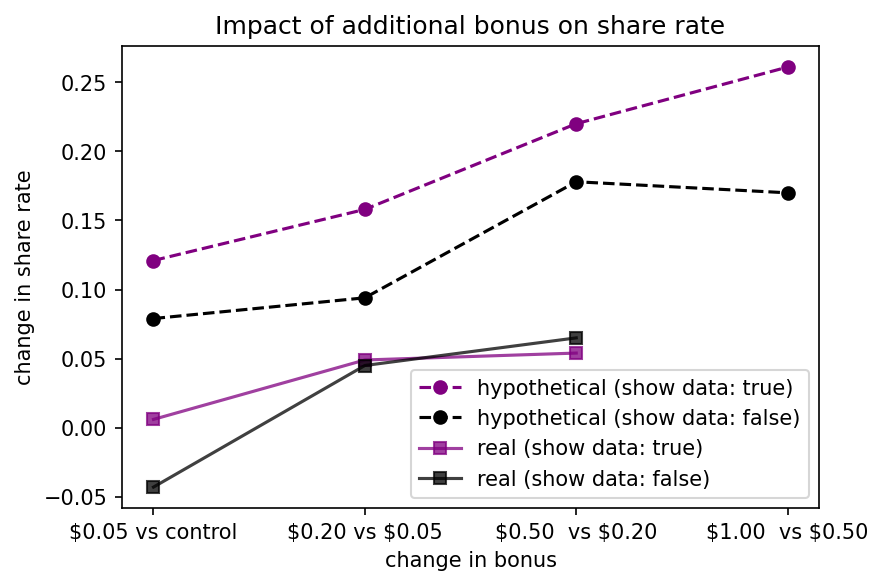

In [87]:
alpha = 0.75
fig,ax = plt.subplots(1,1, figsize=(6,4), dpi=150)

ax.plot(x, hypo_impact_showdata1['hypo impact'], 
        'o--', 
        color='purple', markersize=6,
       label='hypothetical (show data: true)')
ax.plot(x, hypo_impact_showdata0['hypo impact'],
        'o--', 
        color='black', markersize=6,
       label='hypothetical (show data: false)')

ax.plot(x, bonus_real_impact_showdata1, 
        's-', 
        alpha=alpha,
        color='purple', markersize=6,
       label='real (show data: true)')
ax.plot(x, bonus_real_impact_showdata0, 
        's-', 
        alpha=alpha,
        color='black', markersize=6,
       label='real (show data: false)')
ax.legend()
ax.set_xlabel('change in bonus')
ax.set_ylabel('change in share rate')
_ = ax.set_title('Impact of additional bonus on share rate')

##### Question: 
- Are the real impacts statistically significant?
- What is the right way to test this?

To test we do 3 regressions, each restricting data to the 2 incentives compared:

share ~ incentive + showdata

1.
Limit data to  incentives: [control, bonus-05] --> no significant difference
2.
Limit data to  incentives: [bonus-05, bonus-20] --> significant difference
3.
Limit data to  incentives: [bonus-20, bonus-50] --> significant difference

Use the lower amount as the reference value in the regression.


In [88]:
for incentives in [['control', 'bonus-05'], ['bonus-05', 'bonus-20'], ['bonus-20', 'bonus-50']]:
    formula = "share ~ C(incentive, Treatment(reference='%s')) + showdata" % incentives[0]
    print('formula: %s' % formula)
    print('limiting data to incentives:', incentives)
    imdf = df[df['incentive'].isin(incentives)]
    model = smf.logit(formula=formula, data=imdf).fit()
    display(model.summary2())
    display(get_predictors_table(model))

formula: share ~ C(incentive, Treatment(reference='control')) + showdata
limiting data to incentives: ['control', 'bonus-05']
Optimization terminated successfully.
         Current function value: 0.548054
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
=======================================================================================================
Model:                           Logit                         Pseudo R-squared:              0.003    
Dependent Variable:              share                         AIC:                           2790.1120
Date:                            2023-05-23 18:20              BIC:                           2807.6318
No. Observations:                2540                          Log-Likelihood:                -1392.1  
Df Model:                        2                             LL-Null:                       -1395.6  
Df Residuals:                    2537                          LLR p-value:                   0.029501 
Converged:                       1.0000                        Scale:                         1.0000   
No. Iterations:                  5.0000                                                                
-------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|   [0.025 0.975]
-------------------------------------------------------------------------------------------------------
Intercept                                                 1.1050   0.0799 13.8256 0.0000  0.9484 1.2617
C(incentive, Treatment(reference='control'))[T.bonus-05] -0.1031   0.0933 -1.1059 0.2688 -0.2859 0.0797
showdata[T.True]                                          0.2239   0.0935  2.3956 0.0166  0.0407 0.4071
=======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.105,3.019,"[2.582, 3.531]",0.000
"C(incentive, Treatment(reference='control'))[T.bonus-05]",-0.103,0.902,"[0.751, 1.083]",0.269
showdata[T.True],0.224,1.251,"[1.042, 1.502]",0.017


formula: share ~ C(incentive, Treatment(reference='bonus-05')) + showdata
limiting data to incentives: ['bonus-05', 'bonus-20']
Optimization terminated successfully.
         Current function value: 0.528474
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
======================================================================================================
Model:                           Logit                        Pseudo R-squared:             0.009     
Dependent Variable:              share                        AIC:                          2664.2229 
Date:                            2023-05-23 18:20             BIC:                          2681.7130 
No. Observations:                2515                         Log-Likelihood:               -1329.1   
Df Model:                        2                            LL-Null:                      -1341.1   
Df Residuals:                    2512                         LLR p-value:                  6.4579e-06
Converged:                       1.0000                       Scale:                        1.0000    
No. Iterations:                  5.0000                                                               
------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------------------------
Intercept                                                 0.9290   0.0780 11.9139 0.0000 0.7762 1.0818
C(incentive, Treatment(reference='bonus-05'))[T.bonus-20] 0.2726   0.0963  2.8316 0.0046 0.0839 0.4613
showdata[T.True]                                          0.3859   0.0968  3.9844 0.0001 0.1961 0.5757
======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,0.929,2.532,"[2.173, 2.950]",0.000
"C(incentive, Treatment(reference='bonus-05'))[T.bonus-20]",0.273,1.313,"[1.088, 1.586]",0.005
showdata[T.True],0.386,1.471,"[1.217, 1.778]",0.000


formula: share ~ C(incentive, Treatment(reference='bonus-20')) + showdata
limiting data to incentives: ['bonus-20', 'bonus-50']
Optimization terminated successfully.
         Current function value: 0.451445
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                            Results: Logit
======================================================================================================
Model:                           Logit                        Pseudo R-squared:             0.015     
Dependent Variable:              share                        AIC:                          2254.1979 
Date:                            2023-05-23 18:20             BIC:                          2271.6580 
No. Observations:                2490                         Log-Likelihood:               -1124.1   
Df Model:                        2                            LL-Null:                      -1141.0   
Df Residuals:                    2487                         LLR p-value:                  4.5521e-08
Converged:                       1.0000                       Scale:                        1.0000    
No. Iterations:                  6.0000                                                               
------------------------------------------------------------------------------------------------------
                                                          Coef.  Std.Err.    z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------------------------------------
Intercept                                                 1.1733   0.0839 13.9882 0.0000 1.0089 1.3377
C(incentive, Treatment(reference='bonus-20'))[T.bonus-50] 0.4258   0.1082  3.9360 0.0001 0.2138 0.6379
showdata[T.True]                                          0.4534   0.1086  4.1732 0.0000 0.2405 0.6664
======================================================================================================

"""

,B (log odds),Odds Ratio,95% CI for Odds Ratio,P-value
Predictor,,,,
Intercept,1.173,3.233,"[2.743, 3.810]",0.0
"C(incentive, Treatment(reference='bonus-20'))[T.bonus-50]",0.426,1.531,"[1.238, 1.892]",0.0
showdata[T.True],0.453,1.574,"[1.272, 1.947]",0.0


##### Plotting the results

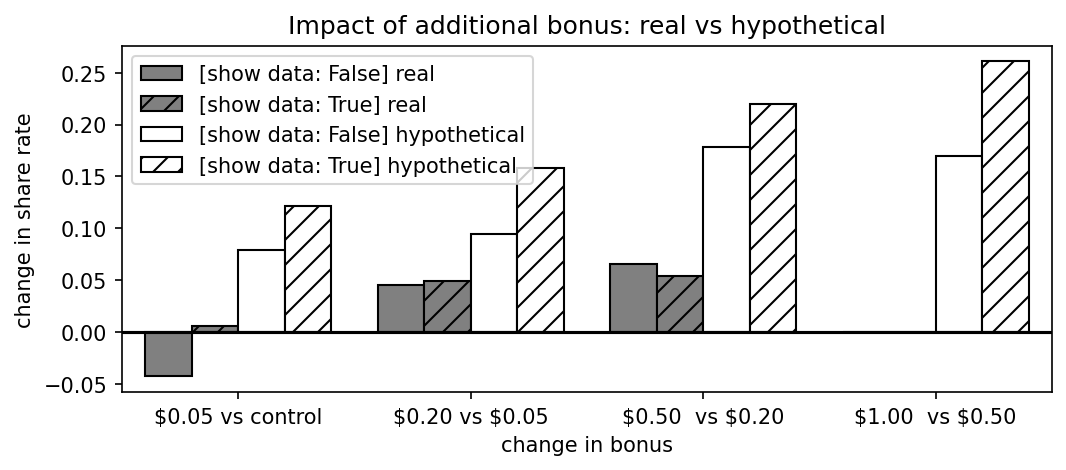

In [89]:
# Use a grouped bar chart to show changes in share rate
width = 0.2
figsize=(8,3)
fig,ax = plt.subplots(1,1, figsize=figsize, dpi=150)
bonus_real_impact_showdata0.plot(kind='bar', ax=ax, width=width, position=2,
         color='gray', edgecolor='black', alpha=1, 
         label='[show data: False] real')
bonus_real_impact_showdata1.plot(kind='bar', ax=ax, width=width, position=1,
         color='gray', edgecolor='black', alpha=1, hatch='//', 
         label='[show data: True] real')

hypo_impact_showdata0['hypo impact'].plot(kind='bar', ax=ax, width=width, position=0,
         color='white', edgecolor='black', alpha=1, 
         label='[show data: False] hypothetical')
hypo_impact_showdata1['hypo impact'].plot(kind='bar', ax=ax, width=width, position=-1,
         color='white', edgecolor='black', alpha=1, hatch='//', 
         label='[show data: True] hypothetical')
# plot y=0
plt.axhline(0, color='black')
ax.legend()
ax.set_xlim([-0.5,3.5])
_ = ax.set_xticklabels(x, rotation=0)
ax.set_xlabel('change in bonus')
ax.set_ylabel('change in share rate')
_ = ax.set_title('Impact of additional bonus: real vs hypothetical')

differences: show data false
0    0.122
1    0.049
2    0.113
3      NaN
dtype: float64
differences: show data true
0    0.115
1    0.109
2    0.166
3      NaN
dtype: float64
differences between the differences:
0   -0.007
1    0.060
2    0.053
3      NaN
dtype: float64


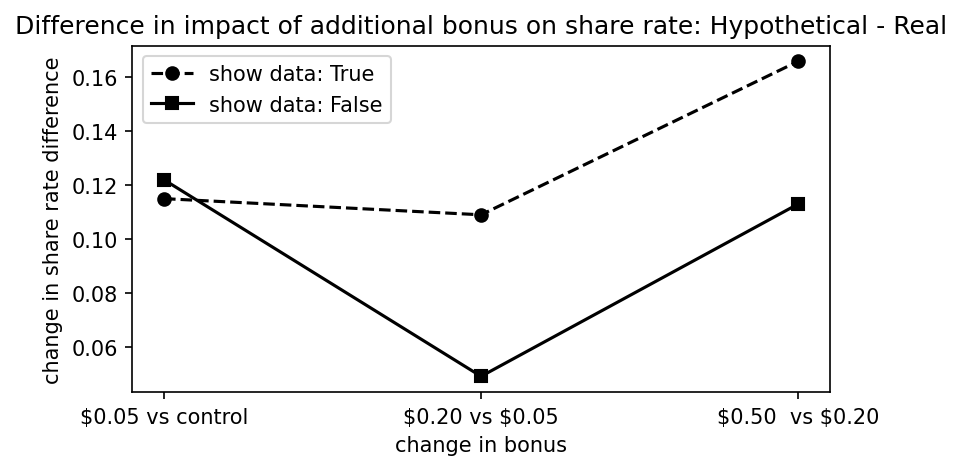

In [90]:
figsize=(6,3)
fig,ax = plt.subplots(1,1, figsize=figsize, dpi=150)

differences_showdata0 = hypo_impact_showdata0['hypo impact'] - bonus_real_impact_showdata0
print('differences: show data false')
print(differences_showdata0)
differences_showdata1 = hypo_impact_showdata1['hypo impact'] - bonus_real_impact_showdata1
print('differences: show data true')
print(differences_showdata1)
print('differences between the differences:')
print(differences_showdata1 - differences_showdata0)
ax.plot(x, differences_showdata1, 
        'o--', 
        color='black', markersize=6,
       label='show data: True')
ax.plot(x, differences_showdata0,
        's-', 
        color='black', markersize=6,
       label='show data: False')
ax.legend()
ax.set_xlabel('change in bonus')
ax.set_ylabel('change in share rate difference')
_ = ax.set_title('Difference in impact of additional bonus on share rate: Hypothetical - Real')

#### Analysis method 3

Uses same strategy for real change in share rate. Hypothetical change calculated differently.

documented [here](https://docs.google.com/document/d/13K_F9sb66HobTmcTljW2wm3L6rrMffIwHQ1xUmmBIYE/edit?pli=1#heading=h.8yccm9pnwviv)



Where:
- s_i = number of people offered bonus_i who did consent to share
- h_i = number of people offered bonus_{i - 1} who did not consent to share but answered they would hypothetically share for bonus_i
- Y_i = (s_{i-1} + h_i) / n_{i - 1}
- eg: Y1 = (# ppl who either shared in control or hypothetically would share for $0.05) / (total # of people in control)
- As a result, hypothetical impact is both: 
    - h_i/n_{i-1}
    - Y_i - X_{i-1}


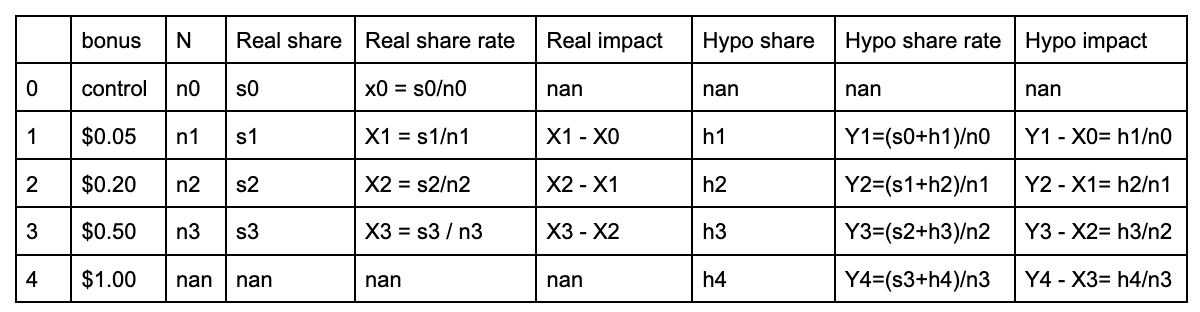

In [201]:
bonus_names = [
    '',
    '\\$0.05 vs control',
    '\\$0.20 vs \\$0.05',
    '\\$0.50 vs \\$0.20',
    '\\$1.00 vs \\$0.50'
]

def get_hypo_shares(df):
    rows = [np.nan]
    iters = [
        ('control','Q-data-value-05'),
        ('bonus-05','Q-data-value-20'),
        ('bonus-20','Q-data-value-50'),
        ('bonus-50','Q-data-value-100'),
    ]
    for (incentive, hypo_Q) in iters:
        sdf = df[df['incentive']==incentive][hypo_Q].apply(lambda a: 1 if a=='Yes' else 0)
        rows.append(sdf.sum())
    return rows

def make_real_hypo_impact_df(df):
    rhdf =  (
        df.groupby(['incentive'])['share'].agg(['count','sum','mean']).round(3)
        .drop('altruism')
        .loc[['control', 'bonus-05', 'bonus-20', 'bonus-50']] # sort index
        .reset_index()
    )
    rhdf.loc[4] = np.nan
    rhdf['bonus'] = bonus_names[:len(rhdf)]
    rhdf['real impact'] = rhdf['mean'] - rhdf.shift(1)['mean']
    # rename columns
    rhdf = rhdf.rename(columns={'count':'n', 'sum':'real share','mean':'real share rate'})
    # reorder the columns
    rhdf = rhdf[['incentive','bonus','n','real share','real share rate','real impact']]
    rhdf['hypo share'] = get_hypo_shares(df)
    # Y_i = (s_{i-1} + h_i) / n_{i - 1}
    rhdf['hypo share rate'] = ((rhdf['real share'].shift(1) + rhdf['hypo share'])/rhdf.shift(1)['n']).round(3)
    # Y4 - X3= h4/n3
    rhdf['hypo impact'] = (rhdf['hypo share']/rhdf.shift(1)['n']).round(3)
    return rhdf
    
real_hypo_impact_showdata0 = make_real_hypo_impact_df(df[df['showdata']==False])
real_hypo_impact_showdata0

,incentive,bonus,n,real share,real share rate,real impact,hypo share,hypo share rate,hypo impact
0,control,,636.0,485.0,0.763,NaN,NaN,NaN,NaN
1,bonus-05,\$0.05 vs control,647.0,466.0,0.720,-0.043,12.0,0.781,0.019
2,bonus-20,\$0.20 vs \$0.05,648.0,496.0,0.765,0.045,17.0,0.747,0.026
3,bonus-50,\$0.50 vs \$0.20,624.0,518.0,0.830,0.065,27.0,0.807,0.042
4,NaN,\$1.00 vs \$0.50,NaN,NaN,NaN,NaN,18.0,0.859,0.029


In [202]:
# make a separate dataframe for showdata true vs false

real_hypo_impact_showdata1 = make_real_hypo_impact_df(df[df['showdata']==True])
print('show data: True')
display(real_hypo_impact_showdata1)

real_hypo_impact_showdata0 = make_real_hypo_impact_df(df[df['showdata']==False])
print('show data: False')
display(real_hypo_impact_showdata0)

show data: True


,incentive,bonus,n,real share,real share rate,real impact,hypo share,hypo share rate,hypo impact
0,control,,639.0,498.0,0.779,NaN,NaN,NaN,NaN
1,bonus-05,\$0.05 vs control,618.0,485.0,0.785,0.006,17.0,0.806,0.027
2,bonus-20,\$0.20 vs \$0.05,602.0,502.0,0.834,0.049,21.0,0.819,0.034
3,bonus-50,\$0.50 vs \$0.20,616.0,547.0,0.888,0.054,22.0,0.870,0.037
4,NaN,\$1.00 vs \$0.50,NaN,NaN,NaN,NaN,18.0,0.917,0.029


show data: False


,incentive,bonus,n,real share,real share rate,real impact,hypo share,hypo share rate,hypo impact
0,control,,636.0,485.0,0.763,NaN,NaN,NaN,NaN
1,bonus-05,\$0.05 vs control,647.0,466.0,0.720,-0.043,12.0,0.781,0.019
2,bonus-20,\$0.20 vs \$0.05,648.0,496.0,0.765,0.045,17.0,0.747,0.026
3,bonus-50,\$0.50 vs \$0.20,624.0,518.0,0.830,0.065,27.0,0.807,0.042
4,NaN,\$1.00 vs \$0.50,NaN,NaN,NaN,NaN,18.0,0.859,0.029


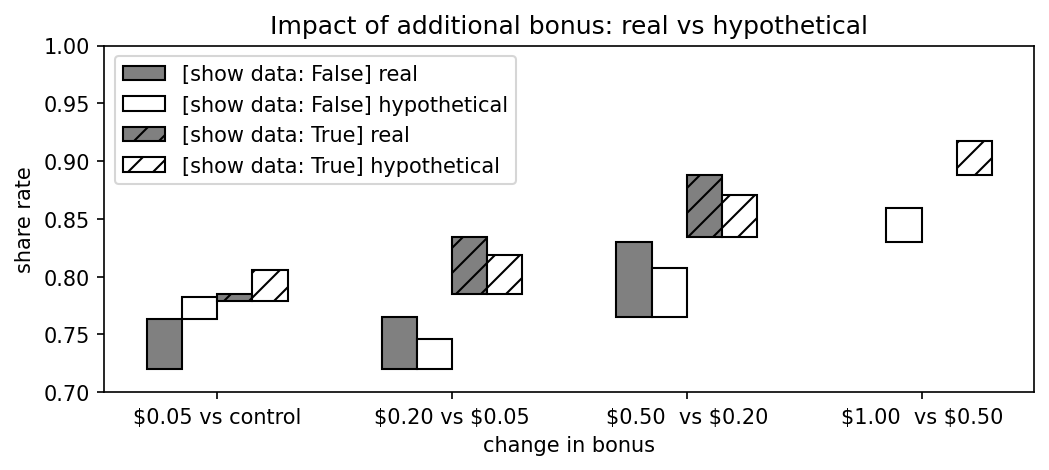

In [225]:
# Use a grouped bar chart to show changes in share rate
width = 0.15 # the width of the bars
multiplier = 0
figsize=(8,3)
fig,ax = plt.subplots(1,1, figsize=figsize, dpi=150)
xticks = np.arange(4)
# showdata:false
ax.bar(xticks + width*multiplier, real_hypo_impact_showdata0.drop(0)['real impact'],
       bottom=real_hypo_impact_showdata0.shift(1).drop(0)['real share rate'],
       width=width, color='gray', edgecolor='black', alpha=1, 
       label='[show data: False] real')
multiplier += 1
ax.bar(xticks + width*multiplier, real_hypo_impact_showdata0.drop(0)['hypo impact'],
       bottom=real_hypo_impact_showdata0.shift(1).drop(0)['real share rate'],
       width=width,
       color='white', edgecolor='black', alpha=1, 
       label='[show data: False] hypothetical')
# showdata: true
multiplier += 1
ax.bar(xticks + width*multiplier, real_hypo_impact_showdata1.drop(0)['real impact'],
       bottom=real_hypo_impact_showdata1.shift(1).drop(0)['real share rate'],
       width=width, color='gray', edgecolor='black', alpha=1,  hatch='//', 
       label='[show data: True] real')
multiplier += 1
ax.bar(xticks + width*multiplier, real_hypo_impact_showdata1.drop(0)['hypo impact'],
       bottom=real_hypo_impact_showdata1.shift(1).drop(0)['real share rate'],
       width=width,
       color='white', edgecolor='black', alpha=1, hatch='//',
       label='[show data: True] hypothetical')
ax.legend()
ax.set_ylim([0.7, 1])
ax.set_xticks(xticks+1.5*width, x)
ax.set_xlabel('change in bonus')
ax.set_ylabel('share rate')
_ = ax.set_title('Impact of additional bonus: real vs hypothetical')

## Questions about data use
At the end of the survey we ask:

- Do you think Amazon should be able to sell YOUR purchase data to other companies?
- Do you think companies should be able to sell consumer purchase data to other companies?
- Big companies currently collect and sell consumer purchase data. Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?
- Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?
- Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?

The order of these questions is randomized.

In [378]:
data_use_Qs = [
    'Q-sell-YOUR-data', 'Q-sell-consumer-data', 'Q-small-biz-use', 'Q-census-use', 'Q-research-society'
]

Overall what were the answers to these questions?




Do you think Amazon should be able to sell YOUR purchase data to other companies?


,count,pct
Q-sell-YOUR-data,,
Yes if I get part of the profit,2936,46.42
Yes,219,3.46
No,2988,47.24
I don't know,182,2.88



Do you think companies should be able to sell consumer purchase data to other companies?


,count,pct
Q-sell-consumer-data,,
Yes if consumers get part of the profit,2857,45.17
Yes,253,4.00
No,2962,46.83
I don't know,253,4.00



Big companies currently collect and sell consumer purchase data.
Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?


,count,pct
Q-small-biz-use,,
Yes,2046,32.35
No,2710,42.85
I don't know,1569,24.81



Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?


,count,pct
Q-census-use,,
Yes,1465,23.16
No,3147,49.75
I don't know,1713,27.08



Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?


,count,pct
Q-research-society,,
Yes,3697,58.45
No,1456,23.02
I don't know,1172,18.53


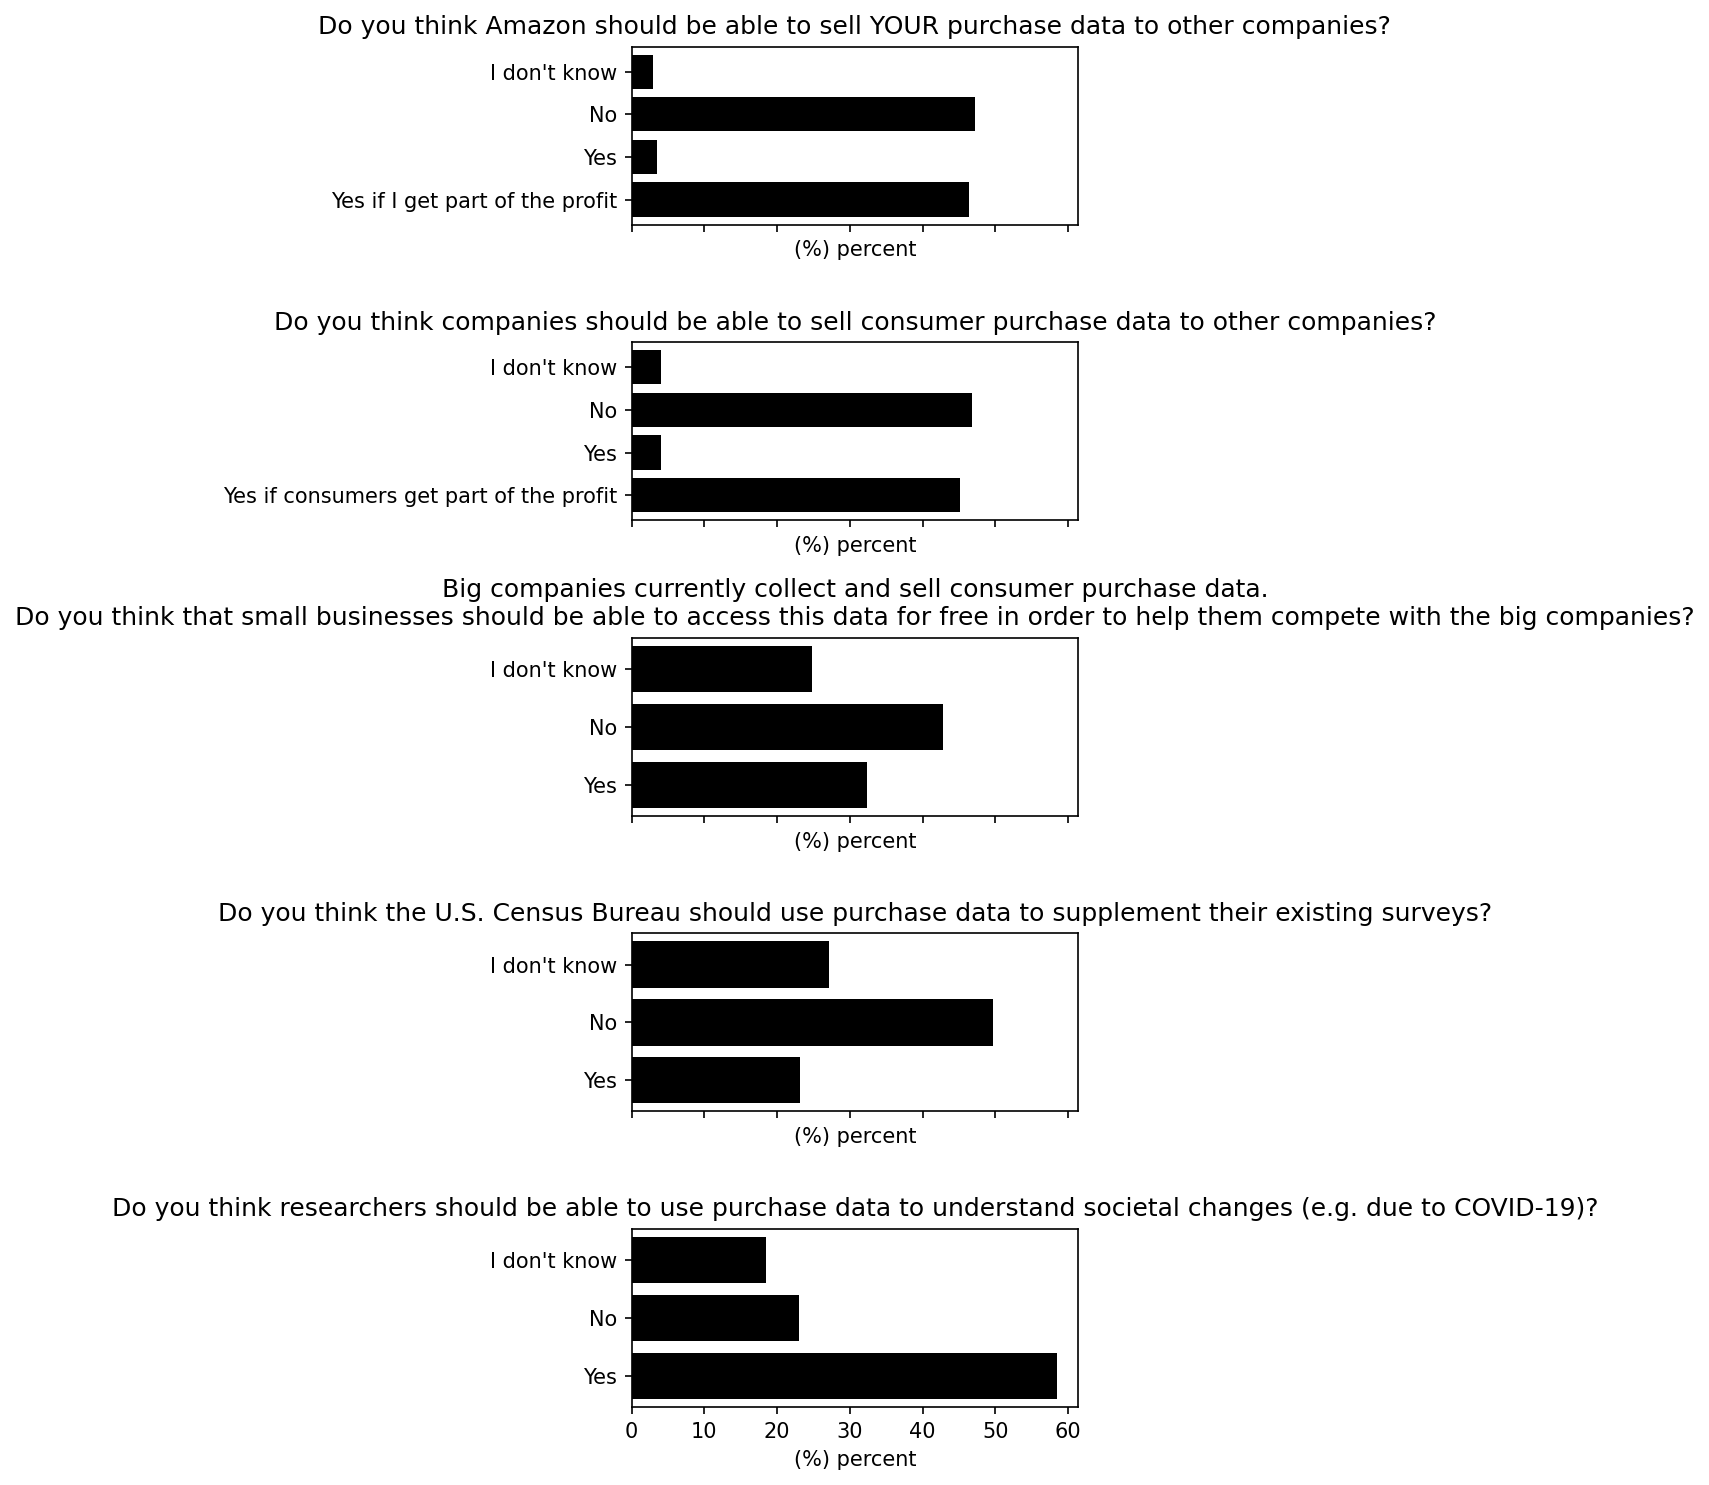

In [379]:
fig, axes = plt.subplots(len(data_use_Qs), 1, figsize=(6, 10), sharex=True, dpi=150)
for i, Q in enumerate(data_use_Qs):
    answers_df = (df[Q].value_counts().sort_index(ascending=False)
              .to_frame(name='count')
              .assign(pct=lambda x: round(100*x['count']/N, 2)))
    ax = axes[i]
    ax.set_xlabel('(%) percent')
    q = fields_df.loc[Q][0].replace('. D', '.\nD')
    print()
    ax.set_title(q)
    ax.barh(answers_df.index, answers_df['pct'], color='black')
    print(q)
    display(answers_df)
plt.tight_layout()
plt.show()

### Relationship between share rate and data use opinions

Research Question:

Is there a relationship between share rate and opinions on data use? (As measured by answers to our data use Q's)

Answer: Yes, and it looks as expected. 
What's surprising is how consistent the result is across Q's.

- People who answered 'No': i.e. do not think data should be used for secondary purposes
    - Also less likely to share data
- People who answered 'Yes': i.e. do think data should be used for secondary purposes
    - Also more likely to share data
- People who answered "I don't know" fall in between


For the larger regression model, may then be sufficient to only use answers to Q 
"Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?"
Given this is also most relevant to our uses.


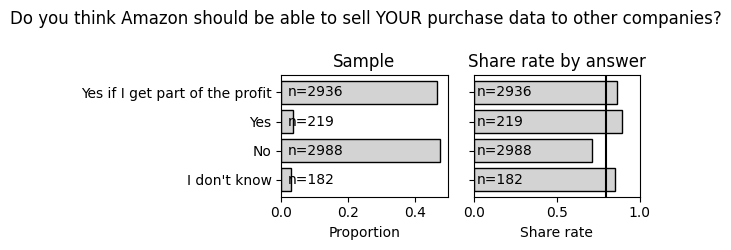

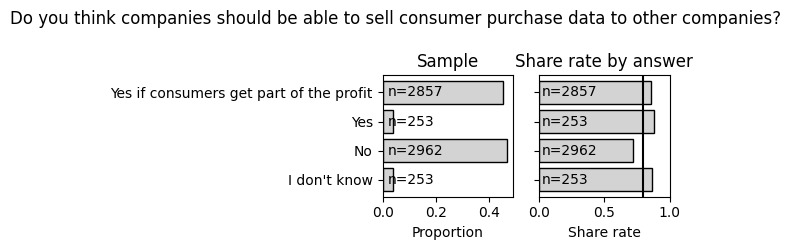

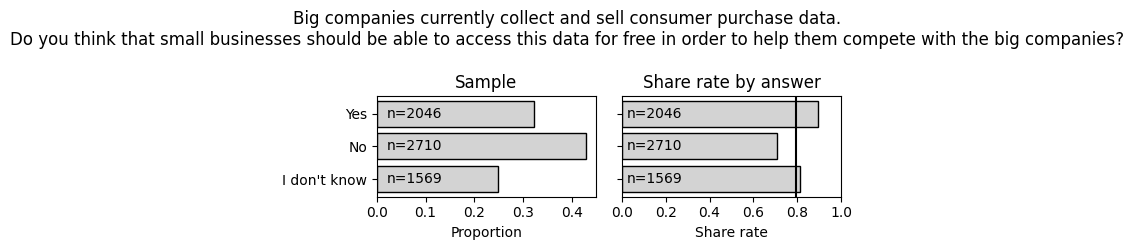

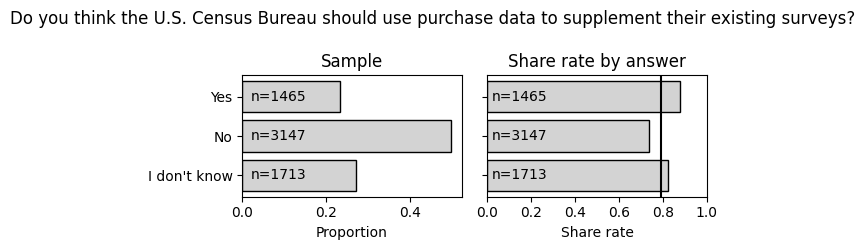

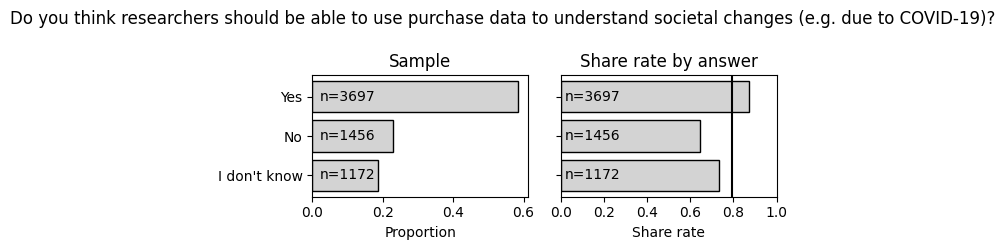

In [380]:
for i, Q in enumerate(data_use_Qs):
    q_df = df[Q].value_counts().rename('survey N').to_frame()
    q_df['survey proportion'] = (q_df['survey N']/q_df['survey N'].sum())
    q_df = q_df.sort_index()
    figsize = (3, 2.5)
    fig, axes = plt.subplots(1,2,figsize=(figsize[0]*2,figsize[1]), dpi=100, sharey=True)
    fig.suptitle(fields_df.loc[Q][0].replace('. D', '.\nD'))
    ax = axes[0]
    plot_survey_proportion_with_N(q_df, ax)
    ax.set_title('Sample')
    colname = 'answer'
    q_share_df = get_share_rate_by_Q_df(Q, colname).sort_index()
    ax = axes[1]
    plot_share_by_demo(q_share_df, colname, ax)
    plt.tight_layout()
    plt.show()
    #display(q_share_df)

#### Relationship between demographics & other covariates and data use opinions

##### Method: 
Logistic regression

limit to answers that are yes=1 or no=0 (exclude “I don’t know” etc)

Regress on yes/no boolean incorporating demographic attributes in model

In [392]:
keep_cols = [
    'q-demos-age', 'Q-demos-hispanic', 'Q-demos-race', 'Q-demos-education', 
    'Q-demos-income', 'Q-demos-gender', 'Q-sexual-orientation', 
    'Q-amazon-use-hh-size', 'Q-amazon-use-how-oft', 
    'Q-sell-YOUR-data', 'Q-sell-consumer-data', 'Q-small-biz-use', 'Q-census-use','Q-research-society',
    'showdata', 'incentive', 'share',
]
dmdf = df[keep_cols]
# gender: restrict to Male/Female binary
dmdf = (
    dmdf[dmdf['Q-demos-gender'].isin(['Male','Female'])]
    .rename({
        'Q-amazon-use-how-oft': 'frequency', # frequency of use
        'Q-demos-education': 'edu',
        'Q-demos-income': 'income', 
        'Q-demos-gender':'gender',
        'Q-demos-race': 'race',
        'q-demos-age': 'age', 
    }, axis=1)
)
# Make very simplifying use of race
dmdf['race'] = dmdf['race'].apply(lambda r: 'Other or 2 or more races' if ((len(r.split(',')) > 1) or ('Other' in r)) else r)
dmdf.head(3)

,age,Q-demos-hispanic,race,edu,income,gender,Q-sexual-orientation,Q-amazon-use-hh-size,frequency,Q-sell-YOUR-data,Q-sell-consumer-data,Q-small-biz-use,Q-census-use,Q-research-society,showdata,incentive,share
0,35 - 44 years,No,Black or African American,High school diploma or GED,"\$25,000 - \$49,999",Female,heterosexual (straight),2,Less than 5 times per month,No,No,No,No,No,False,bonus-50,1
1,25 - 34 years,No,White or Caucasian,Bachelor's degree,"\$25,000 - \$49,999",Male,heterosexual (straight),1 (just me!),Less than 5 times per month,Yes if I get part of the profit,Yes,No,Yes,Yes,False,bonus-05,0
2,45 - 54 years,No,White or Caucasian,High school diploma or GED,"\$100,000 - \$149,999",Male,heterosexual (straight),4+,Less than 5 times per month,No,No,No,No,Yes,False,bonus-05,1


In [396]:
formula = "opinion ~"
formula += " + C(gender) + C(age)"
# median household income ~$70k, use that group as reference
formula += " + C(income, Treatment(reference='\$50,000 - \$74,999'))"
formula += " + C(edu) + C(race, Treatment(reference='White or Caucasian'))"
formula += " + C(frequency)"
print('formula:\n%s\n-------------------' % formula)

for i, Q in enumerate(data_use_Qs):
    print('Q: %s: %s' % (Q, fields_df.loc[Q][0]))
    print(dmdf[Q].value_counts(), 'Total including non Yes/No:', dmdf[Q].value_counts().sum())
    dmdf['opinion'] = dmdf[Q].map({'Yes':1, 'No': 0})
    model = smf.logit(formula=formula, data=dmdf).fit()
    display(model.summary2())

formula:
opinion ~ + C(gender) + C(age) + C(income, Treatment(reference='\$50,000 - \$74,999')) + C(edu) + C(race, Treatment(reference='White or Caucasian')) + C(frequency)
-------------------
Q: Q-sell-YOUR-data: Do you think Amazon should be able to sell YOUR purchase data to other companies?
Q-sell-YOUR-data
No                                 2894
Yes if I get part of the profit    2861
Yes                                 218
I don't know                        179
Name: count, dtype: int64 Total including non Yes/No: 6152
Optimization terminated successfully.
         Current function value: 0.240144
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                    Results: Logit
=======================================================================================================================================================
Model:                                            Logit                                        Pseudo R-squared:                             0.054     
Dependent Variable:                               opinion                                      AIC:                                          1540.6567 
Date:                                             2023-05-19 17:11                             BIC:                                          1679.6461 
No. Observations:                                 3112                                         Log-Likelihood:                               -747.33   
Df Model:                                         22                                           LL-Null:                                      -789.74   
Df Residuals:                                     3089                                         LLR p-value:                                  2.5674e-09
Converged:                                        1.0000                                       Scale:                                        1.0000    
No. Iterations:                                   8.0000                                                                                               
-------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              -3.2478   0.3123 -10.3993 0.0000 -3.8599 -2.6357
C(gender)[T.Male]                                                                                       1.1323   0.1539   7.3574 0.0000  0.8306  1.4339
C(age)[T.25 - 34 years]                                                                                -0.3364   0.2308  -1.4572 0.1451 -0.7888  0.1160
C(age)[T.35 - 44 years]                                                                                -0.4517   0.2436  -1.8541 0.0637 -0.9292  0.0258
C(age)[T.45 - 54 years]                                                                                -0.4091   0.2721  -1.5031 0.1328 -0.9424  0.1243
C(age)[T.55 - 64 years]                                                                                -0.0485   0.2830  -0.1713 0.8640 -0.6032  0.5063
C(age)[T.65 and older]                                                                                 -0.9959   0.4683  -2.1268 0.0334 -1.9137 -0.0781
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                             0.1019   0.2672   0.3813 0.7029 -0.4218  0.6255
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                             -1.2847   1.0343  -1.2421 0.2142 -3.3119  0.7425
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                          0.0781   0.2424   0.3221 0.7474 -0.3971  0.5533
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                              0.3264   0.2620   1.2457 0.2129 -0.1872  0.8400
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                            0.2741   0.2247   1.2199 0.2225 -0.1663  0.7146
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                            0.0843   0.2407   0.3503 0.7261 -0.3874  0.5560
C(edu)[T.Graduate or professional degree]                           

Q: Q-sell-consumer-data: Do you think companies should be able to sell consumer purchase data to other companies?
Q-sell-consumer-data
No                                         2867
Yes if consumers get part of the profit    2783
Yes                                         252
I don't know                                250
Name: count, dtype: int64 Total including non Yes/No: 6152
         Current function value: 0.260508
         Iterations: 35


/Users/aberke/projects/amazon-study/data-analysis/venv-amazon-study/lib/python3.11/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                         Results: Logit
================================================================================================================================================================
Model:                                               Logit                                           Pseudo R-squared:                                0.072     
Dependent Variable:                                  opinion                                         AIC:                                             1671.0499 
Date:                                                2023-05-19 17:11                                BIC:                                             1810.0911 
No. Observations:                                    3119                                            Log-Likelihood:                                  -812.52   
Df Model:                                            22                                              LL-Null:                                         -875.53   
Df Residuals:                                        3096                                            LLR p-value:                                     1.4013e-16
Converged:                                           0.0000                                          Scale:                                           1.0000    
No. Iterations:                                      35.0000                                                                                                    
----------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.    Std.Err.    z     P>|z|     [0.025     0.975]  
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                               -3.3775    0.2981 -11.3317 0.0000     -3.9616    -2.7933
C(gender)[T.Male]                                                                                        1.2838    0.1483   8.6597 0.0000      0.9933     1.5744
C(age)[T.25 - 34 years]                                                                                 -0.3348    0.2165  -1.5464 0.1220     -0.7591     0.0895
C(age)[T.35 - 44 years]                                                                                 -0.4062    0.2286  -1.7773 0.0755     -0.8542     0.0417
C(age)[T.45 - 54 years]                                                                                 -0.3677    0.2562  -1.4353 0.1512     -0.8699     0.1344
C(age)[T.55 - 64 years]                                                                                 -0.0172    0.2676  -0.0644 0.9486     -0.5417     0.5072
C(age)[T.65 and older]                                                                                  -1.8238    0.6183  -2.9494 0.0032     -3.0357    -0.6118
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                              0.3786    0.2402   1.5764 0.1149     -0.0921     0.8494
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                              -1.3582    1.0300  -1.3186 0.1873     -3.3771     0.6606
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                           0.2535    0.2262   1.1207 0.2624     -0.1898     0.6967
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                               0.4630    0.2488   1.8606 0.0628     -0.0247     0.9507
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                             0.2312    0.2176   1.0625 0.2880     -0.1953     0.6577

Q: Q-small-biz-use: Big companies currently collect and sell consumer purchase data. Do you think that small businesses should be able to access this data for free in order to help them compete with the big companies?
Q-small-biz-use
No              2626
Yes             2005
I don't know    1521
Name: count, dtype: int64 Total including non Yes/No: 6152
Optimization terminated successfully.
         Current function value: 0.676775
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                    Results: Logit
======================================================================================================================================================
Model:                                           Logit                                        Pseudo R-squared:                             0.011     
Dependent Variable:                              opinion                                      AIC:                                          6314.2915 
Date:                                            2023-05-19 17:11                             BIC:                                          6462.4237 
No. Observations:                                4631                                         Log-Likelihood:                               -3134.1   
Df Model:                                        22                                           LL-Null:                                      -3168.2   
Df Residuals:                                    4608                                         LLR p-value:                                  1.3062e-06
Converged:                                       1.0000                                       Scale:                                        1.0000    
No. Iterations:                                  5.0000                                                                                               
------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                               0.1861   0.1219  1.5273 0.1267 -0.0527  0.4250
C(gender)[T.Male]                                                                                      -0.2018   0.0606 -3.3295 0.0009 -0.3206 -0.0830
C(age)[T.25 - 34 years]                                                                                -0.1257   0.0942 -1.3343 0.1821 -0.3103  0.0589
C(age)[T.35 - 44 years]                                                                                -0.2836   0.1016 -2.7913 0.0052 -0.4827 -0.0845
C(age)[T.45 - 54 years]                                                                                -0.3710   0.1165 -3.1841 0.0015 -0.5994 -0.1426
C(age)[T.55 - 64 years]                                                                                -0.3976   0.1368 -2.9070 0.0036 -0.6656 -0.1295
C(age)[T.65 and older]                                                                                 -0.6567   0.1998 -3.2864 0.0010 -1.0484 -0.2651
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                            -0.1253   0.1085 -1.1546 0.2483 -0.3381  0.0874
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                             -0.3783   0.2470 -1.5318 0.1256 -0.8624  0.1058
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                         -0.1512   0.1005 -1.5035 0.1327 -0.3482  0.0459
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                             -0.1703   0.1180 -1.4426 0.1491 -0.4016  0.0611
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                           -0.0102   0.0908 -0.1125 0.9104 -0.1882  0.1678
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                           -0.0255   0.0995 -0.2566 0.7975 -0.2205  0.1694
C(edu)[T.Graduate or professional degree]                                                    

Q: Q-census-use: Do you think the U.S. Census Bureau should use purchase data to supplement their existing surveys?
Q-census-use
No              3054
I don't know    1661
Yes             1437
Name: count, dtype: int64 Total including non Yes/No: 6152
Optimization terminated successfully.
         Current function value: 0.602712
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                    Results: Logit
======================================================================================================================================================
Model:                                           Logit                                        Pseudo R-squared:                             0.039     
Dependent Variable:                              opinion                                      AIC:                                          5459.5554 
Date:                                            2023-05-19 17:11                             BIC:                                          5606.9815 
No. Observations:                                4491                                         Log-Likelihood:                               -2706.8   
Df Model:                                        22                                           LL-Null:                                      -2815.2   
Df Residuals:                                    4468                                         LLR p-value:                                  5.6701e-34
Converged:                                       1.0000                                       Scale:                                        1.0000    
No. Iterations:                                  6.0000                                                                                               
------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                              -0.6508   0.1335 -4.8762 0.0000 -0.9123 -0.3892
C(gender)[T.Male]                                                                                       0.5039   0.0672  7.4999 0.0000  0.3722  0.6356
C(age)[T.25 - 34 years]                                                                                -0.3626   0.1002 -3.6169 0.0003 -0.5591 -0.1661
C(age)[T.35 - 44 years]                                                                                -0.6999   0.1091 -6.4147 0.0000 -0.9138 -0.4861
C(age)[T.45 - 54 years]                                                                                -0.9225   0.1286 -7.1753 0.0000 -1.1745 -0.6705
C(age)[T.55 - 64 years]                                                                                -1.0179   0.1566 -6.5016 0.0000 -1.3248 -0.7111
C(age)[T.65 and older]                                                                                 -1.3429   0.2317 -5.7965 0.0000 -1.7970 -0.8888
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                             0.0634   0.1207  0.5257 0.5991 -0.1730  0.2999
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                             -0.4671   0.3013 -1.5504 0.1211 -1.0576  0.1234
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                          0.1901   0.1083  1.7556 0.0792 -0.0221  0.4024
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                              0.2890   0.1249  2.3133 0.0207  0.0441  0.5338
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                            0.0110   0.1017  0.1079 0.9140 -0.1884  0.2103
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                            0.0328   0.1097  0.2992 0.7648 -0.1823  0.2479
C(edu)[T.Graduate or professional degree]                                                    

Q: Q-research-society: Do you think researchers should be able to use purchase data to understand societal changes (e.g. due to COVID-19)?
Q-research-society
Yes             3591
No              1429
I don't know    1132
Name: count, dtype: int64 Total including non Yes/No: 6152
Optimization terminated successfully.
         Current function value: 0.589648
         Iterations 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                                    Results: Logit
======================================================================================================================================================
Model:                                           Logit                                        Pseudo R-squared:                             0.013     
Dependent Variable:                              opinion                                      AIC:                                          5966.0650 
Date:                                            2023-05-19 17:11                             BIC:                                          6116.0522 
No. Observations:                                5020                                         Log-Likelihood:                               -2960.0   
Df Model:                                        22                                           LL-Null:                                      -2998.5   
Df Residuals:                                    4997                                         LLR p-value:                                  5.3083e-08
Converged:                                       1.0000                                       Scale:                                        1.0000    
No. Iterations:                                  5.0000                                                                                               
------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                               1.2936   0.1322  9.7821 0.0000  1.0344  1.5528
C(gender)[T.Male]                                                                                      -0.0485   0.0641 -0.7562 0.4495 -0.1742  0.0772
C(age)[T.25 - 34 years]                                                                                -0.3407   0.1041 -3.2727 0.0011 -0.5447 -0.1366
C(age)[T.35 - 44 years]                                                                                -0.3931   0.1112 -3.5366 0.0004 -0.6110 -0.1752
C(age)[T.45 - 54 years]                                                                                -0.6761   0.1239 -5.4571 0.0000 -0.9189 -0.4333
C(age)[T.55 - 64 years]                                                                                -0.6676   0.1429 -4.6718 0.0000 -0.9477 -0.3875
C(age)[T.65 and older]                                                                                 -0.9604   0.1903 -5.0474 0.0000 -1.3333 -0.5875
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Less than \$25,000]                             0.0195   0.1118  0.1748 0.8613 -0.1996  0.2387
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.Prefer not to say]                             -0.4957   0.2432 -2.0384 0.0415 -0.9723 -0.0191
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$100,000 - \$149,999]                          0.1702   0.1070  1.5899 0.1119 -0.0396  0.3800
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$150,000 or more]                              0.0623   0.1248  0.4991 0.6177 -0.1823  0.3069
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$25,000 - \$49,999]                            0.1326   0.0970  1.3674 0.1715 -0.0575  0.3227
C(income, Treatment(reference='\$50,000 - \$74,999'))[T.\$75,000 - \$99,999]                           -0.0854   0.1043 -0.8185 0.4131 -0.2899  0.1191
C(edu)[T.Graduate or professional degree]                                                    